In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=1

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl',
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    
                    
                   ])
len(ondate_cols)

36

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.02,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
reload(rrvf_data)

<module 'rrvf_data' from '../python/rrvf2017/rrvf_data.pyc'>

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('l4_3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200606, 2) (50134, 2)
train/valid # (200606, 2) (50134, 2)
rand split across time
train has 200606 records out of 389630 records
valid has 50134 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1567
0
(200606, 1, 36) (200606, 7, 32) (200606, 1) (200606, 1)
(200606, 260) (200606,) (200606,)
(50134, 1, 36) (50134, 7, 32) (50134, 1) (50134, 1)
(50134, 260) (50134,) (50134,)
(5803, 1, 36) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 260) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf': 0.001, 'b

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.811535
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.801492
[3]	valid_0's rmse: 0.791861
[4]	valid_0's rmse: 0.782502
[5]	valid_0's rmse: 0.77338
[6]	valid_0's rmse: 0.764434
[7]	valid_0's rmse: 0.755739
[8]	valid_0's rmse: 0.747237
[9]	valid_0's rmse: 0.738964
[10]	valid_0's rmse: 0.731105
[11]	valid_0's rmse: 0.723307
[12]	valid_0's rmse: 0.715817
[13]	valid_0's rmse: 0.70845
[14]	valid_0's rmse: 0.70132
[15]	valid_0's rmse: 0.694516
[16]	valid_0's rmse: 0.687908
[17]	valid_0's rmse: 0.681398
[18]	valid_0's rmse: 0.67509
[19]	valid_0's rmse: 0.668975
[20]	valid_0's rmse: 0.663178
[21]	valid_0's rmse: 0.657457
[22]	valid_0's rmse: 0.652038
[23]	valid_0's rmse: 0.646749
[24]	valid_0's rmse: 0.641613
[25]	valid_0's rmse: 0.636568
[26]	valid_0's rmse: 0.631793
[27]	valid_0's rmse: 0.627068
[28]	valid_0's rmse: 0.622593
[29]	valid_0's rmse: 0.618246
[30]	valid_0's rmse: 0.614054
[31]	valid_0's rmse: 0.609973
[32]	valid_0's rmse: 

[268]	valid_0's rmse: 0.499678
[269]	valid_0's rmse: 0.499682
Early stopping, best iteration is:
[219]	valid_0's rmse: 0.499582
0.22131039786502182 0.2495825188530553
[0.2495825188530553]
-1 mean score 0.2495825188530553
0.199021768861


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925033  0.004076  0.209461    7  2017-04-16
472     2.507290  2.540062 -0.032771  0.212779    1  2017-04-17
473     2.661330  2.672250 -0.010921  0.235802    2  2017-04-18
474     2.754815  2.747421  0.007394  0.192465    3  2017-04-19
475     2.713762  2.716976 -0.003214  0.219326    4  2017-04-20
476     2.999000  2.981952  0.017048  0.148973    5  2017-04-21
477     3.075529  3.080673 -0.005144  0.174346    6  2017-04-22

0.199021768861


pred         y     error    error2  day        date
dayidx                                                         
471     2.925033  2.929110  0.004076  0.209461    7  2017-04-16
472     2.540062  2.507290 -0.032771  0.212779    1  2017-04-17
473     2.672250  2.661330 -0.010921  0.235802    2  2017-04-18
474     2.747421  2.754815  0.007394  0.192465    3  2017-04-19
475     2.716976  2.713762 -0.003214  0.219326    4  2017-04-20
476     2.981952  2.999000  0.017048  0.148973    5  2017-04-21
477     3.080673  3.075529 -0.005144  0.174346    6  2017-04-22

(829, 260)


2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200381, 2) (50076, 2)
train/valid # (200381, 2) (50076, 2)
rand split across time
train has 200381 records out of 389630 records
valid has 50076 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1565
0
(200381, 1, 36) (200381, 7, 32) (200381, 1) (200381, 1)
(200381, 260) (200381,) (200381,)
(50076, 1, 36) (50076, 7, 32) (50076, 1) (50076, 1)
(50076, 260) (50076,) (50076,)
(6632, 1, 36) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 260) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.506208
[237]	valid_0's rmse: 0.506199
[238]	valid_0's rmse: 0.506195
[239]	valid_0's rmse: 0.506191
[240]	valid_0's rmse: 0.506188
[241]	valid_0's rmse: 0.506176
[242]	valid_0's rmse: 0.506183
[243]	valid_0's rmse: 0.506181
[244]	valid_0's rmse: 0.506185
[245]	valid_0's rmse: 0.506183
[246]	valid_0's rmse: 0.50619
[247]	valid_0's rmse: 0.506187
[248]	valid_0's rmse: 0.506198
[249]	valid_0's rmse: 0.506206
[250]	valid_0's rmse: 0.506209
[251]	valid_0's rmse: 0.506199
[252]	valid_0's rmse: 0.506194
[253]	valid_0's rmse: 0.506197
[254]	valid_0's rmse: 0.506195
[255]	valid_0's rmse: 0.50619
[256]	valid_0's rmse: 0.506193
[257]	valid_0's rmse: 0.506197
[258]	valid_0's rmse: 0.506198
[259]	valid_0's rmse: 0.50619
[260]	valid_0's rmse: 0.506186
[261]	valid_0's rmse: 0.506182
[262]	valid_0's rmse: 0.506172
[263]	valid_0's rmse: 0.506179
[264]	valid_0's rmse: 0.506174
[265]	valid_0's rmse: 0.506161
[266]	valid_0's rmse: 0.506161
[267]	valid_0's rmse: 0.506164
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922082  0.007028  0.212129    7  2017-04-16
472     2.507290  2.536938 -0.029647  0.211566    1  2017-04-17
473     2.661330  2.665178 -0.003848  0.232738    2  2017-04-18
474     2.754815  2.746221  0.008594  0.199619    3  2017-04-19
475     2.713762  2.721095 -0.007333  0.224668    4  2017-04-20
476     2.999000  2.991636  0.007364  0.150208    5  2017-04-21
477     3.075529  3.069906  0.005623  0.170695    6  2017-04-22

0.200232004847


pred         y     error    error2  day        date
dayidx                                                         
471     2.922082  2.929110  0.007028  0.212129    7  2017-04-16
472     2.536938  2.507290 -0.029647  0.211566    1  2017-04-17
473     2.665178  2.661330 -0.003848  0.232738    2  2017-04-18
474     2.746221  2.754815  0.008594  0.199619    3  2017-04-19
475     2.721095  2.713762 -0.007333  0.224668    4  2017-04-20
476     2.991636  2.999000  0.007364  0.150208    5  2017-04-21
477     3.069906  3.075529  0.005623  0.170695    6  2017-04-22

(829, 260)


3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200200, 2) (50030, 2)
train/valid # (200200, 2) (50030, 2)
rand split across time
train has 200200 records out of 389630 records
valid has 50030 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1564
0
(200200, 1, 36) (200200, 7, 32) (200200, 1) (200200, 1)
(200200, 260) (200200,) (200200,)
(50030, 1, 36) (50030, 7, 32) (50030, 1) (50030, 1)
(50030, 260) (50030,) (50030,)
(7461, 1, 36) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 260) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.507179
[237]	valid_0's rmse: 0.507179
[238]	valid_0's rmse: 0.507184
[239]	valid_0's rmse: 0.507183
[240]	valid_0's rmse: 0.507178
[241]	valid_0's rmse: 0.507177
[242]	valid_0's rmse: 0.507166
[243]	valid_0's rmse: 0.507168
[244]	valid_0's rmse: 0.507177
[245]	valid_0's rmse: 0.507159
[246]	valid_0's rmse: 0.507165
[247]	valid_0's rmse: 0.507173
[248]	valid_0's rmse: 0.507185
[249]	valid_0's rmse: 0.507187
[250]	valid_0's rmse: 0.507188
[251]	valid_0's rmse: 0.507196
[252]	valid_0's rmse: 0.507183
[253]	valid_0's rmse: 0.507175
[254]	valid_0's rmse: 0.507165
[255]	valid_0's rmse: 0.507169
[256]	valid_0's rmse: 0.507155
[257]	valid_0's rmse: 0.507155
[258]	valid_0's rmse: 0.507162
[259]	valid_0's rmse: 0.507153
[260]	valid_0's rmse: 0.507146
[261]	valid_0's rmse: 0.507154
[262]	valid_0's rmse: 0.507158
[263]	valid_0's rmse: 0.507152
[264]	valid_0's rmse: 0.507146
[265]	valid_0's rmse: 0.507147
[266]	valid_0's rmse: 0.507142
[267]	valid_0's rmse: 0.507145
[268]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900446  0.028664  0.213665    7  2017-04-16
472     2.507290  2.534451 -0.027160  0.215443    1  2017-04-17
473     2.661330  2.655152  0.006178  0.243241    2  2017-04-18
474     2.754815  2.755584 -0.000769  0.204541    3  2017-04-19
475     2.713762  2.717990 -0.004228  0.226001    4  2017-04-20
476     2.999000  2.989334  0.009666  0.150315    5  2017-04-21
477     3.075529  3.068757  0.006773  0.173388    6  2017-04-22

0.203798843277


pred         y     error    error2  day        date
dayidx                                                         
471     2.900446  2.929110  0.028664  0.213665    7  2017-04-16
472     2.534451  2.507290 -0.027160  0.215443    1  2017-04-17
473     2.655152  2.661330  0.006178  0.243241    2  2017-04-18
474     2.755584  2.754815 -0.000769  0.204541    3  2017-04-19
475     2.717990  2.713762 -0.004228  0.226001    4  2017-04-20
476     2.989334  2.999000  0.009666  0.150315    5  2017-04-21
477     3.068757  3.075529  0.006773  0.173388    6  2017-04-22

(829, 260)


4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200042, 2) (49986, 2)
train/valid # (200042, 2) (49986, 2)
rand split across time
train has 200042 records out of 389630 records
valid has 49986 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1562
0
(200042, 1, 36) (200042, 7, 32) (200042, 1) (200042, 1)
(200042, 260) (200042,) (200042,)
(49986, 1, 36) (49986, 7, 32) (49986, 1) (49986, 1)
(49986, 260) (49986,) (49986,)
(8290, 1, 36) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 260) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.509381
[237]	valid_0's rmse: 0.509386
[238]	valid_0's rmse: 0.509396
[239]	valid_0's rmse: 0.509384
[240]	valid_0's rmse: 0.509391
[241]	valid_0's rmse: 0.509402
[242]	valid_0's rmse: 0.509387
[243]	valid_0's rmse: 0.509395
[244]	valid_0's rmse: 0.509394
[245]	valid_0's rmse: 0.509403
[246]	valid_0's rmse: 0.509412
[247]	valid_0's rmse: 0.509412
[248]	valid_0's rmse: 0.509412
[249]	valid_0's rmse: 0.50942
[250]	valid_0's rmse: 0.509432
[251]	valid_0's rmse: 0.509432
[252]	valid_0's rmse: 0.509428
[253]	valid_0's rmse: 0.50943
[254]	valid_0's rmse: 0.509421
[255]	valid_0's rmse: 0.509419
[256]	valid_0's rmse: 0.509413
[257]	valid_0's rmse: 0.50941
[258]	valid_0's rmse: 0.509408
[259]	valid_0's rmse: 0.509414
[260]	valid_0's rmse: 0.509414
[261]	valid_0's rmse: 0.509413
[262]	valid_0's rmse: 0.509404
[263]	valid_0's rmse: 0.509411
[264]	valid_0's rmse: 0.509397
[265]	valid_0's rmse: 0.509407
[266]	valid_0's rmse: 0.509404
[267]	valid_0's rmse: 0.509412
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905390  0.023720  0.221034    7  2017-04-16
472     2.507290  2.528913 -0.021622  0.218902    1  2017-04-17
473     2.661330  2.644766  0.016564  0.242875    2  2017-04-18
474     2.754815  2.743497  0.011318  0.202941    3  2017-04-19
475     2.713762  2.721624 -0.007863  0.228894    4  2017-04-20
476     2.999000  2.980933  0.018066  0.155994    5  2017-04-21
477     3.075529  3.070023  0.005506  0.172536    6  2017-04-22

0.206168019971


pred         y     error    error2  day        date
dayidx                                                         
471     2.905390  2.929110  0.023720  0.221034    7  2017-04-16
472     2.528913  2.507290 -0.021622  0.218902    1  2017-04-17
473     2.644766  2.661330  0.016564  0.242875    2  2017-04-18
474     2.743497  2.754815  0.011318  0.202941    3  2017-04-19
475     2.721624  2.713762 -0.007863  0.228894    4  2017-04-20
476     2.980933  2.999000  0.018066  0.155994    5  2017-04-21
477     3.070023  3.075529  0.005506  0.172536    6  2017-04-22

(829, 260)


5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199839, 2) (49937, 2)
train/valid # (199839, 2) (49937, 2)
rand split across time
train has 199839 records out of 389630 records
valid has 49937 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1561
0
(199839, 1, 36) (199839, 7, 32) (199839, 1) (199839, 1)
(199839, 260) (199839,) (199839,)
(49937, 1, 36) (49937, 7, 32) (49937, 1) (49937, 1)
(49937, 260) (49937,) (49937,)
(9119, 1, 36) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 260) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.510537
[236]	valid_0's rmse: 0.510546
[237]	valid_0's rmse: 0.510538
[238]	valid_0's rmse: 0.510539
[239]	valid_0's rmse: 0.510533
[240]	valid_0's rmse: 0.510537
[241]	valid_0's rmse: 0.510531
[242]	valid_0's rmse: 0.510532
[243]	valid_0's rmse: 0.510542
[244]	valid_0's rmse: 0.510546
[245]	valid_0's rmse: 0.51054
[246]	valid_0's rmse: 0.510547
[247]	valid_0's rmse: 0.510544
[248]	valid_0's rmse: 0.510542
[249]	valid_0's rmse: 0.510537
[250]	valid_0's rmse: 0.510535
[251]	valid_0's rmse: 0.51054
Early stopping, best iteration is:
[201]	valid_0's rmse: 0.510497
0.233861299847744 0.2606069267312067
[0.2606069267312067]
-1 mean score 0.2606069267312067
0.209923415999


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903035  0.026075  0.220844    7  2017-04-16
472     2.507290  2.535260 -0.027970  0.224614    1  2017-04-17
473     2.661330  2.635493  0.025837  0.247656    2  2017-04-18
474     2.754815  2.737290  0.017525  0.205390    3  2017-04-19
475     2.713762  2.714063 -0.000302  0.232478    4  2017-04-20
476     2.999000  2.975753  0.023247  0.161547    5  2017-04-21
477     3.075529  3.064222  0.011307  0.176935    6  2017-04-22

0.209923415999


pred         y     error    error2  day        date
dayidx                                                         
471     2.903035  2.929110  0.026075  0.220844    7  2017-04-16
472     2.535260  2.507290 -0.027970  0.224614    1  2017-04-17
473     2.635493  2.661330  0.025837  0.247656    2  2017-04-18
474     2.737290  2.754815  0.017525  0.205390    3  2017-04-19
475     2.714063  2.713762 -0.000302  0.232478    4  2017-04-20
476     2.975753  2.999000  0.023247  0.161547    5  2017-04-21
477     3.064222  3.075529  0.011307  0.176935    6  2017-04-22

(829, 260)


6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 15.133374
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199631, 2) (49882, 2)
train/valid # (199631, 2) (49882, 2)
rand split across time
train has 199631 records out of 389630 records
valid has 49882 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1559
0
(199631, 1, 36) (199631, 7, 32) (199631, 1) (199631, 1)
(199631, 260) (199631,) (199631,)
(49882, 1, 36) (49882, 7, 32) (49882, 1) (49882, 1)
(49882, 260) (49882,) (49882,)
(9948, 1, 36) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 260) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.512805
[237]	valid_0's rmse: 0.512797
[238]	valid_0's rmse: 0.512798
[239]	valid_0's rmse: 0.512803
[240]	valid_0's rmse: 0.512804
[241]	valid_0's rmse: 0.512813
[242]	valid_0's rmse: 0.512812
[243]	valid_0's rmse: 0.512811
[244]	valid_0's rmse: 0.512806
[245]	valid_0's rmse: 0.512802
[246]	valid_0's rmse: 0.512798
[247]	valid_0's rmse: 0.5128
[248]	valid_0's rmse: 0.512806
[249]	valid_0's rmse: 0.512807
[250]	valid_0's rmse: 0.51281
[251]	valid_0's rmse: 0.512813
[252]	valid_0's rmse: 0.512823
[253]	valid_0's rmse: 0.512828
[254]	valid_0's rmse: 0.51283
[255]	valid_0's rmse: 0.512832
[256]	valid_0's rmse: 0.512834
[257]	valid_0's rmse: 0.51284
[258]	valid_0's rmse: 0.512841
[259]	valid_0's rmse: 0.512845
[260]	valid_0's rmse: 0.512842
[261]	valid_0's rmse: 0.512838
[262]	valid_0's rmse: 0.51285
[263]	valid_0's rmse: 0.51285
[264]	valid_0's rmse: 0.512859
[265]	valid_0's rmse: 0.51286
[266]	valid_0's rmse: 0.512864
[267]	valid_0's rmse: 0.512868
[268]	valid_0's 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914683  0.014427  0.226542    7  2017-04-16
472     2.507290  2.545690 -0.038400  0.232116    1  2017-04-17
473     2.661330  2.640478  0.020852  0.253543    2  2017-04-18
474     2.754815  2.735959  0.018856  0.204347    3  2017-04-19
475     2.713762  2.721315 -0.007553  0.235973    4  2017-04-20
476     2.999000  2.971263  0.027736  0.158710    5  2017-04-21
477     3.075529  3.078713 -0.003184  0.177216    6  2017-04-22

0.212635233053


pred         y     error    error2  day        date
dayidx                                                         
471     2.914683  2.929110  0.014427  0.226542    7  2017-04-16
472     2.545690  2.507290 -0.038400  0.232116    1  2017-04-17
473     2.640478  2.661330  0.020852  0.253543    2  2017-04-18
474     2.735959  2.754815  0.018856  0.204347    3  2017-04-19
475     2.721315  2.713762 -0.007553  0.235973    4  2017-04-20
476     2.971263  2.999000  0.027736  0.158710    5  2017-04-21
477     3.078713  3.075529 -0.003184  0.177216    6  2017-04-22

(829, 260)


7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 16.310143
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199412, 2) (49827, 2)
train/valid # (199412, 2) (49827, 2)
rand split across time
train has 199412 records out of 389630 records
valid has 49827 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1557
0
(199412, 1, 36) (199412, 7, 32) (199412, 1) (199412, 1)
(199412, 260) (199412,) (199412,)
(49827, 1, 36) (49827, 7, 32) (49827, 1) (49827, 1)
(49827, 260) (49827,) (49827,)
(10777, 1, 36) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 260) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.514371
[237]	valid_0's rmse: 0.514364
[238]	valid_0's rmse: 0.514359
[239]	valid_0's rmse: 0.514348
[240]	valid_0's rmse: 0.514354
[241]	valid_0's rmse: 0.514358
[242]	valid_0's rmse: 0.514359
[243]	valid_0's rmse: 0.514365
[244]	valid_0's rmse: 0.514355
[245]	valid_0's rmse: 0.514348
[246]	valid_0's rmse: 0.514351
[247]	valid_0's rmse: 0.514356
[248]	valid_0's rmse: 0.514366
[249]	valid_0's rmse: 0.514367
[250]	valid_0's rmse: 0.514363
[251]	valid_0's rmse: 0.514347
[252]	valid_0's rmse: 0.514345
[253]	valid_0's rmse: 0.514335
[254]	valid_0's rmse: 0.51434
[255]	valid_0's rmse: 0.514349
[256]	valid_0's rmse: 0.514357
[257]	valid_0's rmse: 0.514359
[258]	valid_0's rmse: 0.514359
[259]	valid_0's rmse: 0.514363
[260]	valid_0's rmse: 0.514366
[261]	valid_0's rmse: 0.514365
[262]	valid_0's rmse: 0.514362
[263]	valid_0's rmse: 0.514362
[264]	valid_0's rmse: 0.514366
[265]	valid_0's rmse: 0.514365
[266]	valid_0's rmse: 0.514357
[267]	valid_0's rmse: 0.514372
[268]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911253  0.017857  0.226425    7  2017-04-16
472     2.507290  2.554076 -0.046785  0.232360    1  2017-04-17
473     2.661330  2.650765  0.010564  0.256317    2  2017-04-18
474     2.754815  2.735881  0.018934  0.207617    3  2017-04-19
475     2.713762  2.717252 -0.003490  0.234914    4  2017-04-20
476     2.999000  2.981439  0.017561  0.157148    5  2017-04-21
477     3.075529  3.092233 -0.016704  0.180764    6  2017-04-22

0.213649177715


pred         y     error    error2  day        date
dayidx                                                         
471     2.911253  2.929110  0.017857  0.226425    7  2017-04-16
472     2.554076  2.507290 -0.046785  0.232360    1  2017-04-17
473     2.650765  2.661330  0.010564  0.256317    2  2017-04-18
474     2.735881  2.754815  0.018934  0.207617    3  2017-04-19
475     2.717252  2.713762 -0.003490  0.234914    4  2017-04-20
476     2.981439  2.999000  0.017561  0.157148    5  2017-04-21
477     3.092233  3.075529 -0.016704  0.180764    6  2017-04-22

(829, 260)


8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 17.574337
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199179, 2) (49770, 2)
train/valid # (199179, 2) (49770, 2)
rand split across time
train has 199179 records out of 389630 records
valid has 49770 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1556
0
(199179, 1, 36) (199179, 7, 32) (199179, 1) (199179, 1)
(199179, 260) (199179,) (199179,)
(49770, 1, 36) (49770, 7, 32) (49770, 1) (49770, 1)
(49770, 260) (49770,) (49770,)
(11606, 1, 36) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 260) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[237]	valid_0's rmse: 0.519122
[238]	valid_0's rmse: 0.519121
[239]	valid_0's rmse: 0.519128
[240]	valid_0's rmse: 0.519123
[241]	valid_0's rmse: 0.51912
[242]	valid_0's rmse: 0.519112
[243]	valid_0's rmse: 0.519115
[244]	valid_0's rmse: 0.519118
[245]	valid_0's rmse: 0.519121
[246]	valid_0's rmse: 0.519127
[247]	valid_0's rmse: 0.51914
[248]	valid_0's rmse: 0.51914
[249]	valid_0's rmse: 0.519137
[250]	valid_0's rmse: 0.519137
[251]	valid_0's rmse: 0.519133
[252]	valid_0's rmse: 0.519145
[253]	valid_0's rmse: 0.519155
[254]	valid_0's rmse: 0.51915
[255]	valid_0's rmse: 0.519148
[256]	valid_0's rmse: 0.519151
[257]	valid_0's rmse: 0.51915
[258]	valid_0's rmse: 0.51915
[259]	valid_0's rmse: 0.51916
[260]	valid_0's rmse: 0.519169
[261]	valid_0's rmse: 0.519162
[262]	valid_0's rmse: 0.519168
[263]	valid_0's rmse: 0.519165
[264]	valid_0's rmse: 0.519159
[265]	valid_0's rmse: 0.519155
[266]	valid_0's rmse: 0.519149
[267]	valid_0's rmse: 0.519161
[268]	valid_0's rmse: 0.51917
[269]	valid_0's 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924186  0.004924  0.233712    7  2017-04-16
472     2.507290  2.551405 -0.044115  0.229999    1  2017-04-17
473     2.661330  2.653535  0.007795  0.257642    2  2017-04-18
474     2.754815  2.737119  0.017696  0.215501    3  2017-04-19
475     2.713762  2.717326 -0.003564  0.238619    4  2017-04-20
476     2.999000  2.968085  0.030915  0.164920    5  2017-04-21
477     3.075529  3.087560 -0.012031  0.181090    6  2017-04-22

0.217354650883


pred         y     error    error2  day        date
dayidx                                                         
471     2.924186  2.929110  0.004924  0.233712    7  2017-04-16
472     2.551405  2.507290 -0.044115  0.229999    1  2017-04-17
473     2.653535  2.661330  0.007795  0.257642    2  2017-04-18
474     2.737119  2.754815  0.017696  0.215501    3  2017-04-19
475     2.717326  2.713762 -0.003564  0.238619    4  2017-04-20
476     2.968085  2.999000  0.030915  0.164920    5  2017-04-21
477     3.087560  3.075529 -0.012031  0.181090    6  2017-04-22

(829, 260)


9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 18.806503
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198954, 2) (49713, 2)
train/valid # (198954, 2) (49713, 2)
rand split across time
train has 198954 records out of 389630 records
valid has 49713 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1554
0
(198954, 1, 36) (198954, 7, 32) (198954, 1) (198954, 1)
(198954, 260) (198954,) (198954,)
(49713, 1, 36) (49713, 7, 32) (49713, 1) (49713, 1)
(49713, 260) (49713,) (49713,)
(12435, 1, 36) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 260) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.520824
[235]	valid_0's rmse: 0.520819
[236]	valid_0's rmse: 0.520818
[237]	valid_0's rmse: 0.52083
[238]	valid_0's rmse: 0.520831
[239]	valid_0's rmse: 0.520832
[240]	valid_0's rmse: 0.520843
[241]	valid_0's rmse: 0.520843
[242]	valid_0's rmse: 0.520848
[243]	valid_0's rmse: 0.520839
[244]	valid_0's rmse: 0.520837
[245]	valid_0's rmse: 0.520853
[246]	valid_0's rmse: 0.520848
[247]	valid_0's rmse: 0.520858
[248]	valid_0's rmse: 0.520852
[249]	valid_0's rmse: 0.520856
[250]	valid_0's rmse: 0.520857
[251]	valid_0's rmse: 0.520852
[252]	valid_0's rmse: 0.520852
[253]	valid_0's rmse: 0.520854
[254]	valid_0's rmse: 0.520844
[255]	valid_0's rmse: 0.520836
[256]	valid_0's rmse: 0.520852
[257]	valid_0's rmse: 0.520852
[258]	valid_0's rmse: 0.520854
[259]	valid_0's rmse: 0.520844
[260]	valid_0's rmse: 0.520851
[261]	valid_0's rmse: 0.520839
[262]	valid_0's rmse: 0.520847
[263]	valid_0's rmse: 0.520851
[264]	valid_0's rmse: 0.520856
[265]	valid_0's rmse: 0.520855
[266]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920246  0.008863  0.233071    7  2017-04-16
472     2.507290  2.558541 -0.051250  0.229386    1  2017-04-17
473     2.661330  2.668550 -0.007220  0.260594    2  2017-04-18
474     2.754815  2.733749  0.021066  0.216661    3  2017-04-19
475     2.713762  2.718334 -0.004573  0.235310    4  2017-04-20
476     2.999000  2.967686  0.031314  0.163036    5  2017-04-21
477     3.075529  3.080346 -0.004817  0.179825    6  2017-04-22

0.216840442245


pred         y     error    error2  day        date
dayidx                                                         
471     2.920246  2.929110  0.008863  0.233071    7  2017-04-16
472     2.558541  2.507290 -0.051250  0.229386    1  2017-04-17
473     2.668550  2.661330 -0.007220  0.260594    2  2017-04-18
474     2.733749  2.754815  0.021066  0.216661    3  2017-04-19
475     2.718334  2.713762 -0.004573  0.235310    4  2017-04-20
476     2.967686  2.999000  0.031314  0.163036    5  2017-04-21
477     3.080346  3.075529 -0.004817  0.179825    6  2017-04-22

(829, 260)


10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 19.926521
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198785, 2) (49666, 2)
train/valid # (198785, 2) (49666, 2)
rand split across time
train has 198785 records out of 389630 records
valid has 49666 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1553
0
(198785, 1, 36) (198785, 7, 32) (198785, 1) (198785, 1)
(198785, 260) (198785,) (198785,)
(49666, 1, 36) (49666, 7, 32) (49666, 1) (49666, 1)
(49666, 260) (49666,) (49666,)
(13264, 1, 36) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 260) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.521178
[235]	valid_0's rmse: 0.521161
[236]	valid_0's rmse: 0.52117
[237]	valid_0's rmse: 0.521176
Early stopping, best iteration is:
[187]	valid_0's rmse: 0.521068
0.24425630375070587 0.27151193555364755
[0.27151193555364755]
-1 mean score 0.27151193555364755
0.220289799898


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914362  0.014748  0.237391    7  2017-04-16
472     2.507290  2.552038 -0.044748  0.231406    1  2017-04-17
473     2.661330  2.670722 -0.009392  0.264024    2  2017-04-18
474     2.754815  2.742486  0.012329  0.219879    3  2017-04-19
475     2.713762  2.723901 -0.010140  0.239611    4  2017-04-20
476     2.999000  2.968096  0.030903  0.167023    5  2017-04-21
477     3.075529  3.081036 -0.005506  0.182694    6  2017-04-22

0.220289799898


pred         y     error    error2  day        date
dayidx                                                         
471     2.914362  2.929110  0.014748  0.237391    7  2017-04-16
472     2.552038  2.507290 -0.044748  0.231406    1  2017-04-17
473     2.670722  2.661330 -0.009392  0.264024    2  2017-04-18
474     2.742486  2.754815  0.012329  0.219879    3  2017-04-19
475     2.723901  2.713762 -0.010140  0.239611    4  2017-04-20
476     2.968096  2.999000  0.030903  0.167023    5  2017-04-21
477     3.081036  3.075529 -0.005506  0.182694    6  2017-04-22

(829, 260)


11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 21.05768
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198605, 2) (49620, 2)
train/valid # (198605, 2) (49620, 2)
rand split across time
train has 198605 records out of 389630 records
valid has 49620 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1551
0
(198605, 1, 36) (198605, 7, 32) (198605, 1) (198605, 1)
(198605, 260) (198605,) (198605,)
(49620, 1, 36) (49620, 7, 32) (49620, 1) (49620, 1)
(49620, 260) (49620,) (49620,)
(14093, 1, 36) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 260) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.522076
[235]	valid_0's rmse: 0.522067
[236]	valid_0's rmse: 0.522058
[237]	valid_0's rmse: 0.522057
[238]	valid_0's rmse: 0.522059
[239]	valid_0's rmse: 0.522072
[240]	valid_0's rmse: 0.522066
[241]	valid_0's rmse: 0.522066
[242]	valid_0's rmse: 0.522057
[243]	valid_0's rmse: 0.522051
[244]	valid_0's rmse: 0.522055
[245]	valid_0's rmse: 0.522062
[246]	valid_0's rmse: 0.52207
[247]	valid_0's rmse: 0.522068
[248]	valid_0's rmse: 0.522069
[249]	valid_0's rmse: 0.522077
[250]	valid_0's rmse: 0.52209
[251]	valid_0's rmse: 0.522087
[252]	valid_0's rmse: 0.522086
[253]	valid_0's rmse: 0.522086
[254]	valid_0's rmse: 0.522082
[255]	valid_0's rmse: 0.522086
[256]	valid_0's rmse: 0.522083
[257]	valid_0's rmse: 0.522085
[258]	valid_0's rmse: 0.522092
[259]	valid_0's rmse: 0.522104
[260]	valid_0's rmse: 0.522101
[261]	valid_0's rmse: 0.522097
[262]	valid_0's rmse: 0.522109
[263]	valid_0's rmse: 0.522122
[264]	valid_0's rmse: 0.522125
[265]	valid_0's rmse: 0.522125
Early stop

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904930  0.024180  0.232532    7  2017-04-16
472     2.507290  2.550096 -0.042806  0.229824    1  2017-04-17
473     2.661330  2.663402 -0.002072  0.263564    2  2017-04-18
474     2.754815  2.729898  0.024917  0.214549    3  2017-04-19
475     2.713762  2.731647 -0.017885  0.237057    4  2017-04-20
476     2.999000  2.975453  0.023546  0.165227    5  2017-04-21
477     3.075529  3.067542  0.007987  0.182186    6  2017-04-22

0.217848507002


pred         y     error    error2  day        date
dayidx                                                         
471     2.904930  2.929110  0.024180  0.232532    7  2017-04-16
472     2.550096  2.507290 -0.042806  0.229824    1  2017-04-17
473     2.663402  2.661330 -0.002072  0.263564    2  2017-04-18
474     2.729898  2.754815  0.024917  0.214549    3  2017-04-19
475     2.731647  2.713762 -0.017885  0.237057    4  2017-04-20
476     2.975453  2.999000  0.023546  0.165227    5  2017-04-21
477     3.067542  3.075529  0.007987  0.182186    6  2017-04-22

(829, 260)


12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 22.115147
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198392, 2) (49566, 2)
train/valid # (198392, 2) (49566, 2)
rand split across time
train has 198392 records out of 389630 records
valid has 49566 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1549
0
(198392, 1, 36) (198392, 7, 32) (198392, 1) (198392, 1)
(198392, 260) (198392,) (198392,)
(49566, 1, 36) (49566, 7, 32) (49566, 1) (49566, 1)
(49566, 260) (49566,) (49566,)
(14922, 1, 36) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 260) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.523929
[237]	valid_0's rmse: 0.523936
[238]	valid_0's rmse: 0.523936
[239]	valid_0's rmse: 0.523929
[240]	valid_0's rmse: 0.523939
[241]	valid_0's rmse: 0.523942
[242]	valid_0's rmse: 0.523953
[243]	valid_0's rmse: 0.523955
[244]	valid_0's rmse: 0.52396
[245]	valid_0's rmse: 0.523974
[246]	valid_0's rmse: 0.523982
[247]	valid_0's rmse: 0.523986
[248]	valid_0's rmse: 0.523999
[249]	valid_0's rmse: 0.524007
[250]	valid_0's rmse: 0.52401
[251]	valid_0's rmse: 0.524021
Early stopping, best iteration is:
[201]	valid_0's rmse: 0.523799
0.2449483793518993 0.2743648807939768
[0.2743648807939768]
-1 mean score 0.2743648807939768
0.221986156497


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901291  0.027819  0.241624    7  2017-04-16
472     2.507290  2.551715 -0.044425  0.230268    1  2017-04-17
473     2.661330  2.668419 -0.007090  0.265614    2  2017-04-18
474     2.754815  2.728038  0.026777  0.221098    3  2017-04-19
475     2.713762  2.724336 -0.010575  0.239651    4  2017-04-20
476     2.999000  2.971091  0.027909  0.169822    5  2017-04-21
477     3.075529  3.071980  0.003549  0.185825    6  2017-04-22

0.221986156497


pred         y     error    error2  day        date
dayidx                                                         
471     2.901291  2.929110  0.027819  0.241624    7  2017-04-16
472     2.551715  2.507290 -0.044425  0.230268    1  2017-04-17
473     2.668419  2.661330 -0.007090  0.265614    2  2017-04-18
474     2.728038  2.754815  0.026777  0.221098    3  2017-04-19
475     2.724336  2.713762 -0.010575  0.239651    4  2017-04-20
476     2.971091  2.999000  0.027909  0.169822    5  2017-04-21
477     3.071980  3.075529  0.003549  0.185825    6  2017-04-22

(829, 260)


13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 23.15517
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198182, 2) (49513, 2)
train/valid # (198182, 2) (49513, 2)
rand split across time
train has 198182 records out of 389630 records
valid has 49513 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1548
0
(198182, 1, 36) (198182, 7, 32) (198182, 1) (198182, 1)
(198182, 260) (198182,) (198182,)
(49513, 1, 36) (49513, 7, 32) (49513, 1) (49513, 1)
(49513, 260) (49513,) (49513,)
(15751, 1, 36) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 260) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.524522
[235]	valid_0's rmse: 0.524529
[236]	valid_0's rmse: 0.524541
[237]	valid_0's rmse: 0.524554
[238]	valid_0's rmse: 0.52457
[239]	valid_0's rmse: 0.524568
[240]	valid_0's rmse: 0.524562
[241]	valid_0's rmse: 0.524554
[242]	valid_0's rmse: 0.524567
[243]	valid_0's rmse: 0.524573
[244]	valid_0's rmse: 0.524583
[245]	valid_0's rmse: 0.524587
[246]	valid_0's rmse: 0.524587
[247]	valid_0's rmse: 0.524585
[248]	valid_0's rmse: 0.524589
[249]	valid_0's rmse: 0.524587
[250]	valid_0's rmse: 0.524594
[251]	valid_0's rmse: 0.524591
[252]	valid_0's rmse: 0.524595
[253]	valid_0's rmse: 0.524595
[254]	valid_0's rmse: 0.524605
[255]	valid_0's rmse: 0.524612
[256]	valid_0's rmse: 0.524608
[257]	valid_0's rmse: 0.524612
[258]	valid_0's rmse: 0.524627
[259]	valid_0's rmse: 0.524645
[260]	valid_0's rmse: 0.524647
Early stopping, best iteration is:
[210]	valid_0's rmse: 0.524445
0.24451444530141342 0.2750425233073927
[0.2750425233073927]
-1 mean score 0.2750425233073927
0.220

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909570  0.019540  0.238950    7  2017-04-16
472     2.507290  2.550112 -0.042822  0.232037    1  2017-04-17
473     2.661330  2.671328 -0.009998  0.262554    2  2017-04-18
474     2.754815  2.731804  0.023011  0.221336    3  2017-04-19
475     2.713762  2.729745 -0.015984  0.239928    4  2017-04-20
476     2.999000  2.981052  0.017948  0.165761    5  2017-04-21
477     3.075529  3.066120  0.009410  0.179745    6  2017-04-22

0.220044393684


pred         y     error    error2  day        date
dayidx                                                         
471     2.909570  2.929110  0.019540  0.238950    7  2017-04-16
472     2.550112  2.507290 -0.042822  0.232037    1  2017-04-17
473     2.671328  2.661330 -0.009998  0.262554    2  2017-04-18
474     2.731804  2.754815  0.023011  0.221336    3  2017-04-19
475     2.729745  2.713762 -0.015984  0.239928    4  2017-04-20
476     2.981052  2.999000  0.017948  0.165761    5  2017-04-21
477     3.066120  3.075529  0.009410  0.179745    6  2017-04-22

(829, 260)


14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 24.22639
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197959, 2) (49458, 2)
train/valid # (197959, 2) (49458, 2)
rand split across time
train has 197959 records out of 389630 records
valid has 49458 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1546
0
(197959, 1, 36) (197959, 7, 32) (197959, 1) (197959, 1)
(197959, 260) (197959,) (197959,)
(49458, 1, 36) (49458, 7, 32) (49458, 1) (49458, 1)
(49458, 260) (49458,) (49458,)
(16580, 1, 36) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 260) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.525105
[236]	valid_0's rmse: 0.525113
[237]	valid_0's rmse: 0.525128
[238]	valid_0's rmse: 0.525118
[239]	valid_0's rmse: 0.52512
[240]	valid_0's rmse: 0.525115
[241]	valid_0's rmse: 0.525132
[242]	valid_0's rmse: 0.525134
[243]	valid_0's rmse: 0.52514
[244]	valid_0's rmse: 0.525137
[245]	valid_0's rmse: 0.525157
[246]	valid_0's rmse: 0.525173
[247]	valid_0's rmse: 0.525181
[248]	valid_0's rmse: 0.525172
[249]	valid_0's rmse: 0.525166
[250]	valid_0's rmse: 0.525171
[251]	valid_0's rmse: 0.525169
[252]	valid_0's rmse: 0.525163
[253]	valid_0's rmse: 0.525157
[254]	valid_0's rmse: 0.525162
[255]	valid_0's rmse: 0.525151
[256]	valid_0's rmse: 0.525171
[257]	valid_0's rmse: 0.525171
[258]	valid_0's rmse: 0.525182
[259]	valid_0's rmse: 0.525174
[260]	valid_0's rmse: 0.525186
[261]	valid_0's rmse: 0.525185
[262]	valid_0's rmse: 0.525198
[263]	valid_0's rmse: 0.525203
[264]	valid_0's rmse: 0.525197
[265]	valid_0's rmse: 0.525214
[266]	valid_0's rmse: 0.52521
Early stopp

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901438  0.027672  0.242899    7  2017-04-16
472     2.507290  2.548464 -0.041173  0.231178    1  2017-04-17
473     2.661330  2.667865 -0.006535  0.264345    2  2017-04-18
474     2.754815  2.726755  0.028059  0.224935    3  2017-04-19
475     2.713762  2.727137 -0.013376  0.236156    4  2017-04-20
476     2.999000  2.989682  0.009317  0.162756    5  2017-04-21
477     3.075529  3.074420  0.001109  0.185696    6  2017-04-22

0.221137858251


pred         y     error    error2  day        date
dayidx                                                         
471     2.901438  2.929110  0.027672  0.242899    7  2017-04-16
472     2.548464  2.507290 -0.041173  0.231178    1  2017-04-17
473     2.667865  2.661330 -0.006535  0.264345    2  2017-04-18
474     2.726755  2.754815  0.028059  0.224935    3  2017-04-19
475     2.727137  2.713762 -0.013376  0.236156    4  2017-04-20
476     2.989682  2.999000  0.009317  0.162756    5  2017-04-21
477     3.074420  3.075529  0.001109  0.185696    6  2017-04-22

(829, 260)


15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 25.357664
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197725, 2) (49402, 2)
train/valid # (197725, 2) (49402, 2)
rand split across time
train has 197725 records out of 389630 records
valid has 49402 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1544
0
(197725, 1, 36) (197725, 7, 32) (197725, 1) (197725, 1)
(197725, 260) (197725,) (197725,)
(49402, 1, 36) (49402, 7, 32) (49402, 1) (49402, 1)
(49402, 260) (49402,) (49402,)
(17409, 1, 36) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 260) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.527848
[238]	valid_0's rmse: 0.527831
[239]	valid_0's rmse: 0.527834
[240]	valid_0's rmse: 0.527859
[241]	valid_0's rmse: 0.527872
[242]	valid_0's rmse: 0.527884
[243]	valid_0's rmse: 0.527891
[244]	valid_0's rmse: 0.527897
[245]	valid_0's rmse: 0.527895
[246]	valid_0's rmse: 0.527904
[247]	valid_0's rmse: 0.527907
[248]	valid_0's rmse: 0.527911
[249]	valid_0's rmse: 0.527906
Early stopping, best iteration is:
[199]	valid_0's rmse: 0.527771
0.2492688398763646 0.27854223385185906
[0.27854223385185906]
-1 mean score 0.27854223385185906
0.225658753507


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912707  0.016403  0.248004    7  2017-04-16
472     2.507290  2.550935 -0.043645  0.236758    1  2017-04-17
473     2.661330  2.661174  0.000155  0.273984    2  2017-04-18
474     2.754815  2.725446  0.029368  0.222148    3  2017-04-19
475     2.713762  2.731169 -0.017408  0.245000    4  2017-04-20
476     2.999000  2.987182  0.011818  0.167379    5  2017-04-21
477     3.075529  3.069031  0.006499  0.186339    6  2017-04-22

0.225658753507


pred         y     error    error2  day        date
dayidx                                                         
471     2.912707  2.929110  0.016403  0.248004    7  2017-04-16
472     2.550935  2.507290 -0.043645  0.236758    1  2017-04-17
473     2.661174  2.661330  0.000155  0.273984    2  2017-04-18
474     2.725446  2.754815  0.029368  0.222148    3  2017-04-19
475     2.731169  2.713762 -0.017408  0.245000    4  2017-04-20
476     2.987182  2.999000  0.011818  0.167379    5  2017-04-21
477     3.069031  3.075529  0.006499  0.186339    6  2017-04-22

(829, 260)


16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 26.465925
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197493, 2) (49345, 2)
train/valid # (197493, 2) (49345, 2)
rand split across time
train has 197493 records out of 389630 records
valid has 49345 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1542
0
(197493, 1, 36) (197493, 7, 32) (197493, 1) (197493, 1)
(197493, 260) (197493,) (197493,)
(49345, 1, 36) (49345, 7, 32) (49345, 1) (49345, 1)
(49345, 260) (49345,) (49345,)
(18238, 1, 36) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 260) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.531032
[236]	valid_0's rmse: 0.531028
[237]	valid_0's rmse: 0.531029
[238]	valid_0's rmse: 0.531032
[239]	valid_0's rmse: 0.531036
[240]	valid_0's rmse: 0.531035
[241]	valid_0's rmse: 0.531034
[242]	valid_0's rmse: 0.531027
[243]	valid_0's rmse: 0.531023
[244]	valid_0's rmse: 0.531029
[245]	valid_0's rmse: 0.531029
[246]	valid_0's rmse: 0.531045
[247]	valid_0's rmse: 0.531051
[248]	valid_0's rmse: 0.53107
[249]	valid_0's rmse: 0.531077
[250]	valid_0's rmse: 0.53108
[251]	valid_0's rmse: 0.531083
[252]	valid_0's rmse: 0.531089
[253]	valid_0's rmse: 0.531089
[254]	valid_0's rmse: 0.531088
[255]	valid_0's rmse: 0.531103
[256]	valid_0's rmse: 0.531113
[257]	valid_0's rmse: 0.531118
[258]	valid_0's rmse: 0.531122
[259]	valid_0's rmse: 0.531132
[260]	valid_0's rmse: 0.531132
[261]	valid_0's rmse: 0.531143
[262]	valid_0's rmse: 0.531143
[263]	valid_0's rmse: 0.531147
[264]	valid_0's rmse: 0.531145
[265]	valid_0's rmse: 0.531152
[266]	valid_0's rmse: 0.531155
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907045  0.022065  0.246536    7  2017-04-16
472     2.507290  2.553801 -0.046510  0.235667    1  2017-04-17
473     2.661330  2.655001  0.006329  0.270632    2  2017-04-18
474     2.754815  2.714336  0.040479  0.221121    3  2017-04-19
475     2.713762  2.728465 -0.014704  0.246818    4  2017-04-20
476     2.999000  2.985370  0.013630  0.168397    5  2017-04-21
477     3.075529  3.064684  0.010845  0.185202    6  2017-04-22

0.224910476033


pred         y     error    error2  day        date
dayidx                                                         
471     2.907045  2.929110  0.022065  0.246536    7  2017-04-16
472     2.553801  2.507290 -0.046510  0.235667    1  2017-04-17
473     2.655001  2.661330  0.006329  0.270632    2  2017-04-18
474     2.714336  2.754815  0.040479  0.221121    3  2017-04-19
475     2.728465  2.713762 -0.014704  0.246818    4  2017-04-20
476     2.985370  2.999000  0.013630  0.168397    5  2017-04-21
477     3.064684  3.075529  0.010845  0.185202    6  2017-04-22

(829, 260)


17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 27.605818
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197331, 2) (49305, 2)
train/valid # (197331, 2) (49305, 2)
rand split across time
train has 197331 records out of 389630 records
valid has 49305 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1541
0
(197331, 1, 36) (197331, 7, 32) (197331, 1) (197331, 1)
(197331, 260) (197331,) (197331,)
(49305, 1, 36) (49305, 7, 32) (49305, 1) (49305, 1)
(49305, 260) (49305,) (49305,)
(19067, 1, 36) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 260) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.530856
[238]	valid_0's rmse: 0.530861
[239]	valid_0's rmse: 0.530864
[240]	valid_0's rmse: 0.530859
[241]	valid_0's rmse: 0.530873
[242]	valid_0's rmse: 0.53087
[243]	valid_0's rmse: 0.530863
[244]	valid_0's rmse: 0.530858
[245]	valid_0's rmse: 0.530866
[246]	valid_0's rmse: 0.530865
[247]	valid_0's rmse: 0.530859
[248]	valid_0's rmse: 0.530862
[249]	valid_0's rmse: 0.530871
[250]	valid_0's rmse: 0.530866
[251]	valid_0's rmse: 0.530872
[252]	valid_0's rmse: 0.530864
[253]	valid_0's rmse: 0.530858
[254]	valid_0's rmse: 0.530873
[255]	valid_0's rmse: 0.530879
[256]	valid_0's rmse: 0.530887
[257]	valid_0's rmse: 0.530906
[258]	valid_0's rmse: 0.530897
[259]	valid_0's rmse: 0.530895
[260]	valid_0's rmse: 0.5309
[261]	valid_0's rmse: 0.53091
[262]	valid_0's rmse: 0.53091
[263]	valid_0's rmse: 0.530922
[264]	valid_0's rmse: 0.530911
[265]	valid_0's rmse: 0.530902
[266]	valid_0's rmse: 0.5309
[267]	valid_0's rmse: 0.530889
[268]	valid_0's rmse: 0.530898
[269]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907795  0.021315  0.245803    7  2017-04-16
472     2.507290  2.535786 -0.028495  0.234521    1  2017-04-17
473     2.661330  2.643739  0.017590  0.269922    2  2017-04-18
474     2.754815  2.717009  0.037805  0.226567    3  2017-04-19
475     2.713762  2.723992 -0.010231  0.242035    4  2017-04-20
476     2.999000  2.987948  0.011052  0.171423    5  2017-04-21
477     3.075529  3.057700  0.017829  0.186917    6  2017-04-22

0.225312706559


pred         y     error    error2  day        date
dayidx                                                         
471     2.907795  2.929110  0.021315  0.245803    7  2017-04-16
472     2.535786  2.507290 -0.028495  0.234521    1  2017-04-17
473     2.643739  2.661330  0.017590  0.269922    2  2017-04-18
474     2.717009  2.754815  0.037805  0.226567    3  2017-04-19
475     2.723992  2.713762 -0.010231  0.242035    4  2017-04-20
476     2.987948  2.999000  0.011052  0.171423    5  2017-04-21
477     3.057700  3.075529  0.017829  0.186917    6  2017-04-22

(829, 260)


18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 28.75126
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197143, 2) (49257, 2)
train/valid # (197143, 2) (49257, 2)
rand split across time
train has 197143 records out of 389630 records
valid has 49257 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1540
0
(197143, 1, 36) (197143, 7, 32) (197143, 1) (197143, 1)
(197143, 260) (197143,) (197143,)
(49257, 1, 36) (49257, 7, 32) (49257, 1) (49257, 1)
(49257, 260) (49257,) (49257,)
(19896, 1, 36) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 260) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.531528
[235]	valid_0's rmse: 0.531525
[236]	valid_0's rmse: 0.531529
[237]	valid_0's rmse: 0.531525
[238]	valid_0's rmse: 0.531519
[239]	valid_0's rmse: 0.531511
[240]	valid_0's rmse: 0.531505
[241]	valid_0's rmse: 0.531511
[242]	valid_0's rmse: 0.531521
[243]	valid_0's rmse: 0.531529
[244]	valid_0's rmse: 0.531524
[245]	valid_0's rmse: 0.531528
Early stopping, best iteration is:
[195]	valid_0's rmse: 0.531473
0.25301541853308324 0.2824633710208783
[0.2824633710208783]
-1 mean score 0.2824633710208783
0.228948151027


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910258  0.018852  0.253111    7  2017-04-16
472     2.507290  2.540967 -0.033677  0.238776    1  2017-04-17
473     2.661330  2.647995  0.013334  0.271033    2  2017-04-18
474     2.754815  2.720262  0.034553  0.224749    3  2017-04-19
475     2.713762  2.717770 -0.004009  0.250707    4  2017-04-20
476     2.999000  2.982779  0.016220  0.174477    5  2017-04-21
477     3.075529  3.054960  0.020569  0.189784    6  2017-04-22

0.228948151027


pred         y     error    error2  day        date
dayidx                                                         
471     2.910258  2.929110  0.018852  0.253111    7  2017-04-16
472     2.540967  2.507290 -0.033677  0.238776    1  2017-04-17
473     2.647995  2.661330  0.013334  0.271033    2  2017-04-18
474     2.720262  2.754815  0.034553  0.224749    3  2017-04-19
475     2.717770  2.713762 -0.004009  0.250707    4  2017-04-20
476     2.982779  2.999000  0.016220  0.174477    5  2017-04-21
477     3.054960  3.075529  0.020569  0.189784    6  2017-04-22

(829, 260)


19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 29.798643
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196929, 2) (49206, 2)
train/valid # (196929, 2) (49206, 2)
rand split across time
train has 196929 records out of 389630 records
valid has 49206 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1538
0
(196929, 1, 36) (196929, 7, 32) (196929, 1) (196929, 1)
(196929, 260) (196929,) (196929,)
(49206, 1, 36) (49206, 7, 32) (49206, 1) (49206, 1)
(49206, 260) (49206,) (49206,)
(20725, 1, 36) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 260) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.531945
[238]	valid_0's rmse: 0.531946
[239]	valid_0's rmse: 0.531941
[240]	valid_0's rmse: 0.531942
[241]	valid_0's rmse: 0.531958
[242]	valid_0's rmse: 0.531963
[243]	valid_0's rmse: 0.531959
[244]	valid_0's rmse: 0.531961
[245]	valid_0's rmse: 0.531965
[246]	valid_0's rmse: 0.531967
[247]	valid_0's rmse: 0.531964
[248]	valid_0's rmse: 0.531958
[249]	valid_0's rmse: 0.531957
[250]	valid_0's rmse: 0.531957
[251]	valid_0's rmse: 0.531966
[252]	valid_0's rmse: 0.531981
[253]	valid_0's rmse: 0.531994
[254]	valid_0's rmse: 0.531985
[255]	valid_0's rmse: 0.531983
Early stopping, best iteration is:
[205]	valid_0's rmse: 0.531839
0.25283861967200844 0.282852288680699
[0.282852288680699]
-1 mean score 0.282852288680699
0.228980790718


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915130  0.013980  0.254107    7  2017-04-16
472     2.507290  2.547806 -0.040516  0.238615    1  2017-04-17
473     2.661330  2.644111  0.017219  0.266998    2  2017-04-18
474     2.754815  2.717050  0.037765  0.228516    3  2017-04-19
475     2.713762  2.717204 -0.003442  0.248337    4  2017-04-20
476     2.999000  2.968693  0.030307  0.174666    5  2017-04-21
477     3.075529  3.056807  0.018723  0.191627    6  2017-04-22

0.228980790718


pred         y     error    error2  day        date
dayidx                                                         
471     2.915130  2.929110  0.013980  0.254107    7  2017-04-16
472     2.547806  2.507290 -0.040516  0.238615    1  2017-04-17
473     2.644111  2.661330  0.017219  0.266998    2  2017-04-18
474     2.717050  2.754815  0.037765  0.228516    3  2017-04-19
475     2.717204  2.713762 -0.003442  0.248337    4  2017-04-20
476     2.968693  2.999000  0.030307  0.174666    5  2017-04-21
477     3.056807  3.075529  0.018723  0.191627    6  2017-04-22

(829, 260)


20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 30.796307
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196711, 2) (49150, 2)
train/valid # (196711, 2) (49150, 2)
rand split across time
train has 196711 records out of 389630 records
valid has 49150 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1536
0
(196711, 1, 36) (196711, 7, 32) (196711, 1) (196711, 1)
(196711, 260) (196711,) (196711,)
(49150, 1, 36) (49150, 7, 32) (49150, 1) (49150, 1)
(49150, 260) (49150,) (49150,)
(21554, 1, 36) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 260) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.532649
[237]	valid_0's rmse: 0.532642
[238]	valid_0's rmse: 0.532641
[239]	valid_0's rmse: 0.532639
[240]	valid_0's rmse: 0.532646
[241]	valid_0's rmse: 0.532643
[242]	valid_0's rmse: 0.532638
[243]	valid_0's rmse: 0.532622
[244]	valid_0's rmse: 0.532632
[245]	valid_0's rmse: 0.532634
[246]	valid_0's rmse: 0.532628
[247]	valid_0's rmse: 0.532616
[248]	valid_0's rmse: 0.532638
[249]	valid_0's rmse: 0.532646
[250]	valid_0's rmse: 0.532658
[251]	valid_0's rmse: 0.532647
[252]	valid_0's rmse: 0.53264
[253]	valid_0's rmse: 0.532647
[254]	valid_0's rmse: 0.532644
[255]	valid_0's rmse: 0.532632
Early stopping, best iteration is:
[205]	valid_0's rmse: 0.532561
0.2533358810343605 0.2836207514707868
[0.2836207514707868]
-1 mean score 0.2836207514707868
0.229132739053


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920688  0.008422  0.247259    7  2017-04-16
472     2.507290  2.553809 -0.046519  0.238112    1  2017-04-17
473     2.661330  2.648127  0.013202  0.270380    2  2017-04-18
474     2.754815  2.721142  0.033673  0.227399    3  2017-04-19
475     2.713762  2.715859 -0.002098  0.254565    4  2017-04-20
476     2.999000  2.966843  0.032157  0.174319    5  2017-04-21
477     3.075529  3.056070  0.019459  0.191895    6  2017-04-22

0.229132739053


pred         y     error    error2  day        date
dayidx                                                         
471     2.920688  2.929110  0.008422  0.247259    7  2017-04-16
472     2.553809  2.507290 -0.046519  0.238112    1  2017-04-17
473     2.648127  2.661330  0.013202  0.270380    2  2017-04-18
474     2.721142  2.754815  0.033673  0.227399    3  2017-04-19
475     2.715859  2.713762 -0.002098  0.254565    4  2017-04-20
476     2.966843  2.999000  0.032157  0.174319    5  2017-04-21
477     3.056070  3.075529  0.019459  0.191895    6  2017-04-22

(829, 260)


21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 31.792852
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196485, 2) (49095, 2)
train/valid # (196485, 2) (49095, 2)
rand split across time
train has 196485 records out of 389630 records
valid has 49095 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1535
0
(196485, 1, 36) (196485, 7, 32) (196485, 1) (196485, 1)
(196485, 260) (196485,) (196485,)
(49095, 1, 36) (49095, 7, 32) (49095, 1) (49095, 1)
(49095, 260) (49095,) (49095,)
(22383, 1, 36) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 260) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.533415
[237]	valid_0's rmse: 0.53341
[238]	valid_0's rmse: 0.533403
[239]	valid_0's rmse: 0.533402
[240]	valid_0's rmse: 0.533403
[241]	valid_0's rmse: 0.533387
[242]	valid_0's rmse: 0.533379
[243]	valid_0's rmse: 0.533377
[244]	valid_0's rmse: 0.533399
[245]	valid_0's rmse: 0.533392
[246]	valid_0's rmse: 0.533404
[247]	valid_0's rmse: 0.533406
[248]	valid_0's rmse: 0.533419
[249]	valid_0's rmse: 0.533428
[250]	valid_0's rmse: 0.533428
[251]	valid_0's rmse: 0.533428
[252]	valid_0's rmse: 0.533427
[253]	valid_0's rmse: 0.533413
[254]	valid_0's rmse: 0.533414
[255]	valid_0's rmse: 0.533421
[256]	valid_0's rmse: 0.53343
[257]	valid_0's rmse: 0.533424
[258]	valid_0's rmse: 0.533423
Early stopping, best iteration is:
[208]	valid_0's rmse: 0.533293
0.2538754095687709 0.28440139180542
[0.28440139180542]
-1 mean score 0.28440139180542
0.229617830862


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898289  0.030821  0.253749    7  2017-04-16
472     2.507290  2.551988 -0.044697  0.239823    1  2017-04-17
473     2.661330  2.653077  0.008253  0.268743    2  2017-04-18
474     2.754815  2.721898  0.032917  0.225653    3  2017-04-19
475     2.713762  2.702882  0.010880  0.252609    4  2017-04-20
476     2.999000  2.963963  0.035037  0.177618    5  2017-04-21
477     3.075529  3.060982  0.014547  0.189131    6  2017-04-22

0.229617830862


pred         y     error    error2  day        date
dayidx                                                         
471     2.898289  2.929110  0.030821  0.253749    7  2017-04-16
472     2.551988  2.507290 -0.044697  0.239823    1  2017-04-17
473     2.653077  2.661330  0.008253  0.268743    2  2017-04-18
474     2.721898  2.754815  0.032917  0.225653    3  2017-04-19
475     2.702882  2.713762  0.010880  0.252609    4  2017-04-20
476     2.963963  2.999000  0.035037  0.177618    5  2017-04-21
477     3.060982  3.075529  0.014547  0.189131    6  2017-04-22

(829, 260)


22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 32.870983
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 389630 records
valid has 49037 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1533
0
(196255, 1, 36) (196255, 7, 32) (196255, 1) (196255, 1)
(196255, 260) (196255,) (196255,)
(49037, 1, 36) (49037, 7, 32) (49037, 1) (49037, 1)
(49037, 260) (49037,) (49037,)
(23212, 1, 36) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 260) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.535592
[236]	valid_0's rmse: 0.535606
[237]	valid_0's rmse: 0.535612
[238]	valid_0's rmse: 0.535638
[239]	valid_0's rmse: 0.535647
[240]	valid_0's rmse: 0.535657
[241]	valid_0's rmse: 0.535652
[242]	valid_0's rmse: 0.535653
[243]	valid_0's rmse: 0.535672
[244]	valid_0's rmse: 0.535674
[245]	valid_0's rmse: 0.53569
[246]	valid_0's rmse: 0.535679
[247]	valid_0's rmse: 0.535666
[248]	valid_0's rmse: 0.535669
[249]	valid_0's rmse: 0.535682
[250]	valid_0's rmse: 0.535677
[251]	valid_0's rmse: 0.535675
[252]	valid_0's rmse: 0.535677
[253]	valid_0's rmse: 0.535693
Early stopping, best iteration is:
[203]	valid_0's rmse: 0.535484
0.25611623324302324 0.28674349558994666
[0.28674349558994666]
-1 mean score 0.28674349558994666
0.229619498393


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912140  0.016970  0.249928    7  2017-04-16
472     2.507290  2.531363 -0.024073  0.237937    1  2017-04-17
473     2.661330  2.655973  0.005357  0.268478    2  2017-04-18
474     2.754815  2.727972  0.026843  0.226194    3  2017-04-19
475     2.713762  2.709285  0.004476  0.255703    4  2017-04-20
476     2.999000  2.961431  0.037569  0.177649    5  2017-04-21
477     3.075529  3.056915  0.018614  0.191447    6  2017-04-22

0.229619498393


pred         y     error    error2  day        date
dayidx                                                         
471     2.912140  2.929110  0.016970  0.249928    7  2017-04-16
472     2.531363  2.507290 -0.024073  0.237937    1  2017-04-17
473     2.655973  2.661330  0.005357  0.268478    2  2017-04-18
474     2.727972  2.754815  0.026843  0.226194    3  2017-04-19
475     2.709285  2.713762  0.004476  0.255703    4  2017-04-20
476     2.961431  2.999000  0.037569  0.177649    5  2017-04-21
477     3.056915  3.075529  0.018614  0.191447    6  2017-04-22

(829, 260)


23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 33.974537
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196025, 2) (48978, 2)
train/valid # (196025, 2) (48978, 2)
rand split across time
train has 196025 records out of 389630 records
valid has 48978 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1531
0
(196025, 1, 36) (196025, 7, 32) (196025, 1) (196025, 1)
(196025, 260) (196025,) (196025,)
(48978, 1, 36) (48978, 7, 32) (48978, 1) (48978, 1)
(48978, 260) (48978,) (48978,)
(24041, 1, 36) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 260) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.537707
[237]	valid_0's rmse: 0.537714
[238]	valid_0's rmse: 0.537705
[239]	valid_0's rmse: 0.537698
[240]	valid_0's rmse: 0.53769
[241]	valid_0's rmse: 0.537691
[242]	valid_0's rmse: 0.537704
[243]	valid_0's rmse: 0.537702
[244]	valid_0's rmse: 0.537708
[245]	valid_0's rmse: 0.537699
[246]	valid_0's rmse: 0.537694
[247]	valid_0's rmse: 0.537706
[248]	valid_0's rmse: 0.537709
[249]	valid_0's rmse: 0.537697
[250]	valid_0's rmse: 0.537697
[251]	valid_0's rmse: 0.537698
[252]	valid_0's rmse: 0.537688
[253]	valid_0's rmse: 0.537694
[254]	valid_0's rmse: 0.537691
[255]	valid_0's rmse: 0.537694
[256]	valid_0's rmse: 0.537697
[257]	valid_0's rmse: 0.537701
[258]	valid_0's rmse: 0.537698
[259]	valid_0's rmse: 0.537687
[260]	valid_0's rmse: 0.537688
[261]	valid_0's rmse: 0.537697
Early stopping, best iteration is:
[211]	valid_0's rmse: 0.53762
0.25666189276249146 0.289035206980022
[0.289035206980022]
-1 mean score 0.289035206980022
0.229129073395


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912195  0.016915  0.248226    7  2017-04-16
472     2.507290  2.535318 -0.028027  0.237470    1  2017-04-17
473     2.661330  2.659654  0.001675  0.265625    2  2017-04-18
474     2.754815  2.730353  0.024462  0.227627    3  2017-04-19
475     2.713762  2.719232 -0.005471  0.253798    4  2017-04-20
476     2.999000  2.967611  0.031389  0.181778    5  2017-04-21
477     3.075529  3.056290  0.019239  0.189379    6  2017-04-22

0.229129073395


pred         y     error    error2  day        date
dayidx                                                         
471     2.912195  2.929110  0.016915  0.248226    7  2017-04-16
472     2.535318  2.507290 -0.028027  0.237470    1  2017-04-17
473     2.659654  2.661330  0.001675  0.265625    2  2017-04-18
474     2.730353  2.754815  0.024462  0.227627    3  2017-04-19
475     2.719232  2.713762 -0.005471  0.253798    4  2017-04-20
476     2.967611  2.999000  0.031389  0.181778    5  2017-04-21
477     3.056290  3.075529  0.019239  0.189379    6  2017-04-22

(829, 260)


24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 35.208443
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195855, 2) (48933, 2)
train/valid # (195855, 2) (48933, 2)
rand split across time
train has 195855 records out of 389630 records
valid has 48933 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1530
0
(195855, 1, 36) (195855, 7, 32) (195855, 1) (195855, 1)
(195855, 260) (195855,) (195855,)
(48933, 1, 36) (48933, 7, 32) (48933, 1) (48933, 1)
(48933, 260) (48933,) (48933,)
(24870, 1, 36) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 260) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.538216
[238]	valid_0's rmse: 0.538213
[239]	valid_0's rmse: 0.5382
[240]	valid_0's rmse: 0.538204
[241]	valid_0's rmse: 0.538207
[242]	valid_0's rmse: 0.538204
[243]	valid_0's rmse: 0.538222
[244]	valid_0's rmse: 0.538223
[245]	valid_0's rmse: 0.538222
[246]	valid_0's rmse: 0.538233
[247]	valid_0's rmse: 0.53823
[248]	valid_0's rmse: 0.538244
[249]	valid_0's rmse: 0.538257
[250]	valid_0's rmse: 0.538267
[251]	valid_0's rmse: 0.538266
[252]	valid_0's rmse: 0.538278
[253]	valid_0's rmse: 0.538278
[254]	valid_0's rmse: 0.538279
[255]	valid_0's rmse: 0.538278
Early stopping, best iteration is:
[205]	valid_0's rmse: 0.538088
0.257664552140397 0.2895382289581674
[0.2895382289581674]
-1 mean score 0.2895382289581674
0.22928249336


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913453  0.015657  0.248706    7  2017-04-16
472     2.507290  2.527315 -0.020024  0.237636    1  2017-04-17
473     2.661330  2.650424  0.010906  0.265167    2  2017-04-18
474     2.754815  2.733385  0.021430  0.229917    3  2017-04-19
475     2.713762  2.718891 -0.005129  0.254307    4  2017-04-20
476     2.999000  2.975372  0.023627  0.177652    5  2017-04-21
477     3.075529  3.054486  0.021043  0.191592    6  2017-04-22

0.22928249336


pred         y     error    error2  day        date
dayidx                                                         
471     2.913453  2.929110  0.015657  0.248706    7  2017-04-16
472     2.527315  2.507290 -0.020024  0.237636    1  2017-04-17
473     2.650424  2.661330  0.010906  0.265167    2  2017-04-18
474     2.733385  2.754815  0.021430  0.229917    3  2017-04-19
475     2.718891  2.713762 -0.005129  0.254307    4  2017-04-20
476     2.975372  2.999000  0.023627  0.177652    5  2017-04-21
477     3.054486  3.075529  0.021043  0.191592    6  2017-04-22

(829, 260)


25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 36.335064
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195669, 2) (48889, 2)
train/valid # (195669, 2) (48889, 2)
rand split across time
train has 195669 records out of 389630 records
valid has 48889 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1528
0
(195669, 1, 36) (195669, 7, 32) (195669, 1) (195669, 1)
(195669, 260) (195669,) (195669,)
(48889, 1, 36) (48889, 7, 32) (48889, 1) (48889, 1)
(48889, 260) (48889,) (48889,)
(25699, 1, 36) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 260) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.539432
[235]	valid_0's rmse: 0.539427
[236]	valid_0's rmse: 0.539426
[237]	valid_0's rmse: 0.539432
[238]	valid_0's rmse: 0.539418
[239]	valid_0's rmse: 0.539431
[240]	valid_0's rmse: 0.539453
[241]	valid_0's rmse: 0.539452
[242]	valid_0's rmse: 0.53946
[243]	valid_0's rmse: 0.539475
[244]	valid_0's rmse: 0.539483
[245]	valid_0's rmse: 0.539485
[246]	valid_0's rmse: 0.539481
Early stopping, best iteration is:
[196]	valid_0's rmse: 0.539329
0.259772765900492 0.29087577921359103
[0.29087577921359103]
-1 mean score 0.29087577921359103
0.232092748325


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912934  0.016175  0.253674    7  2017-04-16
472     2.507290  2.524225 -0.016935  0.243745    1  2017-04-17
473     2.661330  2.655120  0.006210  0.268470    2  2017-04-18
474     2.754815  2.719662  0.035153  0.232046    3  2017-04-19
475     2.713762  2.703919  0.009843  0.256284    4  2017-04-20
476     2.999000  2.977976  0.021023  0.174525    5  2017-04-21
477     3.075529  3.062179  0.013350  0.195905    6  2017-04-22

0.232092748325


pred         y     error    error2  day        date
dayidx                                                         
471     2.912934  2.929110  0.016175  0.253674    7  2017-04-16
472     2.524225  2.507290 -0.016935  0.243745    1  2017-04-17
473     2.655120  2.661330  0.006210  0.268470    2  2017-04-18
474     2.719662  2.754815  0.035153  0.232046    3  2017-04-19
475     2.703919  2.713762  0.009843  0.256284    4  2017-04-20
476     2.977976  2.999000  0.021023  0.174525    5  2017-04-21
477     3.062179  3.075529  0.013350  0.195905    6  2017-04-22

(829, 260)


26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 37.374123
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195451, 2) (48836, 2)
train/valid # (195451, 2) (48836, 2)
rand split across time
train has 195451 records out of 389630 records
valid has 48836 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1526
0
(195451, 1, 36) (195451, 7, 32) (195451, 1) (195451, 1)
(195451, 260) (195451,) (195451,)
(48836, 1, 36) (48836, 7, 32) (48836, 1) (48836, 1)
(48836, 260) (48836,) (48836,)
(26528, 1, 36) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 260) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.54057
[236]	valid_0's rmse: 0.540575
[237]	valid_0's rmse: 0.540571
[238]	valid_0's rmse: 0.540584
[239]	valid_0's rmse: 0.540589
[240]	valid_0's rmse: 0.540596
[241]	valid_0's rmse: 0.540597
[242]	valid_0's rmse: 0.540601
[243]	valid_0's rmse: 0.540605
[244]	valid_0's rmse: 0.540608
[245]	valid_0's rmse: 0.540601
[246]	valid_0's rmse: 0.540616
[247]	valid_0's rmse: 0.540623
[248]	valid_0's rmse: 0.540642
[249]	valid_0's rmse: 0.540644
[250]	valid_0's rmse: 0.540662
[251]	valid_0's rmse: 0.540664
[252]	valid_0's rmse: 0.540663
Early stopping, best iteration is:
[202]	valid_0's rmse: 0.54045
0.25969782533025293 0.29208595362452006
[0.29208595362452006]
-1 mean score 0.29208595362452006
0.23329859301


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910654  0.018456  0.264273    7  2017-04-16
472     2.507290  2.534613 -0.027323  0.240358    1  2017-04-17
473     2.661330  2.654447  0.006883  0.272061    2  2017-04-18
474     2.754815  2.722846  0.031968  0.229705    3  2017-04-19
475     2.713762  2.706367  0.007394  0.257255    4  2017-04-20
476     2.999000  2.973036  0.025964  0.177290    5  2017-04-21
477     3.075529  3.064813  0.010716  0.192150    6  2017-04-22

0.23329859301


pred         y     error    error2  day        date
dayidx                                                         
471     2.910654  2.929110  0.018456  0.264273    7  2017-04-16
472     2.534613  2.507290 -0.027323  0.240358    1  2017-04-17
473     2.654447  2.661330  0.006883  0.272061    2  2017-04-18
474     2.722846  2.754815  0.031968  0.229705    3  2017-04-19
475     2.706367  2.713762  0.007394  0.257255    4  2017-04-20
476     2.973036  2.999000  0.025964  0.177290    5  2017-04-21
477     3.064813  3.075529  0.010716  0.192150    6  2017-04-22

(829, 260)


27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 38.450596
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195240, 2) (48779, 2)
train/valid # (195240, 2) (48779, 2)
rand split across time
train has 195240 records out of 389630 records
valid has 48779 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1525
0
(195240, 1, 36) (195240, 7, 32) (195240, 1) (195240, 1)
(195240, 260) (195240,) (195240,)
(48779, 1, 36) (48779, 7, 32) (48779, 1) (48779, 1)
(48779, 260) (48779,) (48779,)
(27357, 1, 36) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 260) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.540698
[236]	valid_0's rmse: 0.540688
[237]	valid_0's rmse: 0.540694
[238]	valid_0's rmse: 0.540697
[239]	valid_0's rmse: 0.540697
[240]	valid_0's rmse: 0.54071
[241]	valid_0's rmse: 0.540712
[242]	valid_0's rmse: 0.54071
[243]	valid_0's rmse: 0.540719
[244]	valid_0's rmse: 0.540734
[245]	valid_0's rmse: 0.54073
[246]	valid_0's rmse: 0.540742
Early stopping, best iteration is:
[196]	valid_0's rmse: 0.540591
0.2608788775135835 0.29223906715549575
[0.29223906715549575]
-1 mean score 0.29223906715549575
0.232527147182


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897538  0.031572  0.256371    7  2017-04-16
472     2.507290  2.540906 -0.033616  0.244987    1  2017-04-17
473     2.661330  2.662376 -0.001047  0.269791    2  2017-04-18
474     2.754815  2.731090  0.023725  0.229189    3  2017-04-19
475     2.713762  2.709229  0.004533  0.256416    4  2017-04-20
476     2.999000  2.962781  0.036219  0.177803    5  2017-04-21
477     3.075529  3.063474  0.012056  0.193133    6  2017-04-22

0.232527147182


pred         y     error    error2  day        date
dayidx                                                         
471     2.897538  2.929110  0.031572  0.256371    7  2017-04-16
472     2.540906  2.507290 -0.033616  0.244987    1  2017-04-17
473     2.662376  2.661330 -0.001047  0.269791    2  2017-04-18
474     2.731090  2.754815  0.023725  0.229189    3  2017-04-19
475     2.709229  2.713762  0.004533  0.256416    4  2017-04-20
476     2.962781  2.999000  0.036219  0.177803    5  2017-04-21
477     3.063474  3.075529  0.012056  0.193133    6  2017-04-22

(829, 260)


28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 39.47981
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195014, 2) (48724, 2)
train/valid # (195014, 2) (48724, 2)
rand split across time
train has 195014 records out of 389630 records
valid has 48724 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1523
0
(195014, 1, 36) (195014, 7, 32) (195014, 1) (195014, 1)
(195014, 260) (195014,) (195014,)
(48724, 1, 36) (48724, 7, 32) (48724, 1) (48724, 1)
(48724, 260) (48724,) (48724,)
(28186, 1, 36) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 260) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[237]	valid_0's rmse: 0.540547
[238]	valid_0's rmse: 0.540557
[239]	valid_0's rmse: 0.540554
[240]	valid_0's rmse: 0.540556
[241]	valid_0's rmse: 0.540557
[242]	valid_0's rmse: 0.540562
[243]	valid_0's rmse: 0.540561
[244]	valid_0's rmse: 0.540559
[245]	valid_0's rmse: 0.540551
[246]	valid_0's rmse: 0.540556
[247]	valid_0's rmse: 0.540568
[248]	valid_0's rmse: 0.540561
[249]	valid_0's rmse: 0.540571
[250]	valid_0's rmse: 0.540572
[251]	valid_0's rmse: 0.540578
[252]	valid_0's rmse: 0.54059
[253]	valid_0's rmse: 0.540593
[254]	valid_0's rmse: 0.540595
[255]	valid_0's rmse: 0.540591
[256]	valid_0's rmse: 0.540601
[257]	valid_0's rmse: 0.540606
[258]	valid_0's rmse: 0.540608
[259]	valid_0's rmse: 0.54061
[260]	valid_0's rmse: 0.54061
[261]	valid_0's rmse: 0.540614
[262]	valid_0's rmse: 0.540615
[263]	valid_0's rmse: 0.540616
Early stopping, best iteration is:
[213]	valid_0's rmse: 0.540432
0.25895482881617665 0.29206668876205694
[0.29206668876205694]
-1 mean score 0.29206668876205694
0.23

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923663  0.005447  0.256891    7  2017-04-16
472     2.507290  2.541878 -0.034587  0.248744    1  2017-04-17
473     2.661330  2.655356  0.005973  0.267478    2  2017-04-18
474     2.754815  2.731015  0.023799  0.231735    3  2017-04-19
475     2.713762  2.709142  0.004620  0.257638    4  2017-04-20
476     2.999000  2.978291  0.020708  0.176793    5  2017-04-21
477     3.075529  3.072626  0.002904  0.193198    6  2017-04-22

0.2332109026


pred         y     error    error2  day        date
dayidx                                                         
471     2.923663  2.929110  0.005447  0.256891    7  2017-04-16
472     2.541878  2.507290 -0.034587  0.248744    1  2017-04-17
473     2.655356  2.661330  0.005973  0.267478    2  2017-04-18
474     2.731015  2.754815  0.023799  0.231735    3  2017-04-19
475     2.709142  2.713762  0.004620  0.257638    4  2017-04-20
476     2.978291  2.999000  0.020708  0.176793    5  2017-04-21
477     3.072626  3.075529  0.002904  0.193198    6  2017-04-22

(829, 260)


29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 40.793427
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194777, 2) (48666, 2)
train/valid # (194777, 2) (48666, 2)
rand split across time
train has 194777 records out of 389630 records
valid has 48666 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1521
0
(194777, 1, 36) (194777, 7, 32) (194777, 1) (194777, 1)
(194777, 260) (194777,) (194777,)
(48666, 1, 36) (48666, 7, 32) (48666, 1) (48666, 1)
(48666, 260) (48666,) (48666,)
(29015, 1, 36) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 260) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.543062
[236]	valid_0's rmse: 0.54308
[237]	valid_0's rmse: 0.543066
[238]	valid_0's rmse: 0.543046
[239]	valid_0's rmse: 0.543061
[240]	valid_0's rmse: 0.543058
[241]	valid_0's rmse: 0.54307
[242]	valid_0's rmse: 0.54308
[243]	valid_0's rmse: 0.543097
[244]	valid_0's rmse: 0.543102
[245]	valid_0's rmse: 0.543106
[246]	valid_0's rmse: 0.543131
[247]	valid_0's rmse: 0.543143
[248]	valid_0's rmse: 0.543152
[249]	valid_0's rmse: 0.543163
[250]	valid_0's rmse: 0.543183
[251]	valid_0's rmse: 0.543175
[252]	valid_0's rmse: 0.543169
[253]	valid_0's rmse: 0.54318
[254]	valid_0's rmse: 0.543177
[255]	valid_0's rmse: 0.543176
[256]	valid_0's rmse: 0.5432
[257]	valid_0's rmse: 0.543203
[258]	valid_0's rmse: 0.543209
[259]	valid_0's rmse: 0.543217
[260]	valid_0's rmse: 0.543218
[261]	valid_0's rmse: 0.543209
[262]	valid_0's rmse: 0.543217
[263]	valid_0's rmse: 0.543219
[264]	valid_0's rmse: 0.543228
[265]	valid_0's rmse: 0.543237
[266]	valid_0's rmse: 0.543254
[267]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903891  0.025219  0.248047    7  2017-04-16
472     2.507290  2.541680 -0.034389  0.240991    1  2017-04-17
473     2.661330  2.655033  0.006296  0.269074    2  2017-04-18
474     2.754815  2.726322  0.028493  0.235882    3  2017-04-19
475     2.713762  2.709305  0.004456  0.254812    4  2017-04-20
476     2.999000  2.985363  0.013636  0.175576    5  2017-04-21
477     3.075529  3.068936  0.006593  0.195336    6  2017-04-22

0.231388520751


pred         y     error    error2  day        date
dayidx                                                         
471     2.903891  2.929110  0.025219  0.248047    7  2017-04-16
472     2.541680  2.507290 -0.034389  0.240991    1  2017-04-17
473     2.655033  2.661330  0.006296  0.269074    2  2017-04-18
474     2.726322  2.754815  0.028493  0.235882    3  2017-04-19
475     2.709305  2.713762  0.004456  0.254812    4  2017-04-20
476     2.985363  2.999000  0.013636  0.175576    5  2017-04-21
477     3.068936  3.075529  0.006593  0.195336    6  2017-04-22

(829, 260)


30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 41.98585
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194547, 2) (48612, 2)
train/valid # (194547, 2) (48612, 2)
rand split across time
train has 194547 records out of 389630 records
valid has 48612 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1519
0
(194547, 1, 36) (194547, 7, 32) (194547, 1) (194547, 1)
(194547, 260) (194547,) (194547,)
(48612, 1, 36) (48612, 7, 32) (48612, 1) (48612, 1)
(48612, 260) (48612,) (48612,)
(29844, 1, 36) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 260) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.545204
[236]	valid_0's rmse: 0.545191
[237]	valid_0's rmse: 0.545183
[238]	valid_0's rmse: 0.545179
[239]	valid_0's rmse: 0.545178
[240]	valid_0's rmse: 0.545171
[241]	valid_0's rmse: 0.545175
[242]	valid_0's rmse: 0.54519
[243]	valid_0's rmse: 0.545184
[244]	valid_0's rmse: 0.545188
[245]	valid_0's rmse: 0.545196
[246]	valid_0's rmse: 0.545199
[247]	valid_0's rmse: 0.545202
[248]	valid_0's rmse: 0.545198
[249]	valid_0's rmse: 0.54521
[250]	valid_0's rmse: 0.545206
[251]	valid_0's rmse: 0.545233
[252]	valid_0's rmse: 0.545236
Early stopping, best iteration is:
[202]	valid_0's rmse: 0.544984
0.2645724890383837 0.29700747190320104
[0.29700747190320104]
-1 mean score 0.29700747190320104
0.23276439668


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902418  0.026691  0.256356    7  2017-04-16
472     2.507290  2.541001 -0.033711  0.239730    1  2017-04-17
473     2.661330  2.643926  0.017403  0.275086    2  2017-04-18
474     2.754815  2.730171  0.024644  0.235260    3  2017-04-19
475     2.713762  2.709860  0.003902  0.253578    4  2017-04-20
476     2.999000  2.985558  0.013441  0.176805    5  2017-04-21
477     3.075529  3.074110  0.001419  0.192535    6  2017-04-22

0.23276439668


pred         y     error    error2  day        date
dayidx                                                         
471     2.902418  2.929110  0.026691  0.256356    7  2017-04-16
472     2.541001  2.507290 -0.033711  0.239730    1  2017-04-17
473     2.643926  2.661330  0.017403  0.275086    2  2017-04-18
474     2.730171  2.754815  0.024644  0.235260    3  2017-04-19
475     2.709860  2.713762  0.003902  0.253578    4  2017-04-20
476     2.985558  2.999000  0.013441  0.176805    5  2017-04-21
477     3.074110  3.075529  0.001419  0.192535    6  2017-04-22

(829, 260)


31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 43.22814
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194381, 2) (48569, 2)
train/valid # (194381, 2) (48569, 2)
rand split across time
train has 194381 records out of 389630 records
valid has 48569 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1518
0
(194381, 1, 36) (194381, 7, 32) (194381, 1) (194381, 1)
(194381, 260) (194381,) (194381,)
(48569, 1, 36) (48569, 7, 32) (48569, 1) (48569, 1)
(48569, 260) (48569,) (48569,)
(30673, 1, 36) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 260) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.545099
[237]	valid_0's rmse: 0.545112
[238]	valid_0's rmse: 0.54512
[239]	valid_0's rmse: 0.545143
[240]	valid_0's rmse: 0.545147
[241]	valid_0's rmse: 0.545147
[242]	valid_0's rmse: 0.545148
[243]	valid_0's rmse: 0.545152
[244]	valid_0's rmse: 0.545161
[245]	valid_0's rmse: 0.545157
[246]	valid_0's rmse: 0.54516
[247]	valid_0's rmse: 0.545155
[248]	valid_0's rmse: 0.545146
[249]	valid_0's rmse: 0.545153
[250]	valid_0's rmse: 0.545157
[251]	valid_0's rmse: 0.545164
[252]	valid_0's rmse: 0.54516
[253]	valid_0's rmse: 0.545154
[254]	valid_0's rmse: 0.545154
[255]	valid_0's rmse: 0.545152
[256]	valid_0's rmse: 0.54515
[257]	valid_0's rmse: 0.545142
[258]	valid_0's rmse: 0.545147
[259]	valid_0's rmse: 0.545147
[260]	valid_0's rmse: 0.545138
[261]	valid_0's rmse: 0.545141
[262]	valid_0's rmse: 0.545146
[263]	valid_0's rmse: 0.545149
[264]	valid_0's rmse: 0.545161
[265]	valid_0's rmse: 0.545174
Early stopping, best iteration is:
[215]	valid_0's rmse: 0.545026
0.263280

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900866  0.028244  0.256837    7  2017-04-16
472     2.507290  2.536160 -0.028869  0.239799    1  2017-04-17
473     2.661330  2.635335  0.025995  0.281186    2  2017-04-18
474     2.754815  2.727481  0.027333  0.235972    3  2017-04-19
475     2.713762  2.707798  0.005963  0.254764    4  2017-04-20
476     2.999000  2.980661  0.018339  0.175041    5  2017-04-21
477     3.075529  3.069850  0.005680  0.193332    6  2017-04-22

0.233847344494


pred         y     error    error2  day        date
dayidx                                                         
471     2.900866  2.929110  0.028244  0.256837    7  2017-04-16
472     2.536160  2.507290 -0.028869  0.239799    1  2017-04-17
473     2.635335  2.661330  0.025995  0.281186    2  2017-04-18
474     2.727481  2.754815  0.027333  0.235972    3  2017-04-19
475     2.707798  2.713762  0.005963  0.254764    4  2017-04-20
476     2.980661  2.999000  0.018339  0.175041    5  2017-04-21
477     3.069850  3.075529  0.005680  0.193332    6  2017-04-22

(829, 260)


32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 44.446426
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194190, 2) (48520, 2)
train/valid # (194190, 2) (48520, 2)
rand split across time
train has 194190 records out of 389630 records
valid has 48520 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1517
0
(194190, 1, 36) (194190, 7, 32) (194190, 1) (194190, 1)
(194190, 260) (194190,) (194190,)
(48520, 1, 36) (48520, 7, 32) (48520, 1) (48520, 1)
(48520, 260) (48520,) (48520,)
(31502, 1, 36) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 260) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.546325
[237]	valid_0's rmse: 0.546337
[238]	valid_0's rmse: 0.546345
[239]	valid_0's rmse: 0.546347
[240]	valid_0's rmse: 0.546389
[241]	valid_0's rmse: 0.546394
[242]	valid_0's rmse: 0.546398
[243]	valid_0's rmse: 0.546392
[244]	valid_0's rmse: 0.546389
[245]	valid_0's rmse: 0.546401
[246]	valid_0's rmse: 0.546401
[247]	valid_0's rmse: 0.546408
[248]	valid_0's rmse: 0.546408
[249]	valid_0's rmse: 0.546403
[250]	valid_0's rmse: 0.546409
[251]	valid_0's rmse: 0.546413
[252]	valid_0's rmse: 0.54642
[253]	valid_0's rmse: 0.546425
[254]	valid_0's rmse: 0.54643
[255]	valid_0's rmse: 0.546424
[256]	valid_0's rmse: 0.546436
[257]	valid_0's rmse: 0.546453
[258]	valid_0's rmse: 0.546462
[259]	valid_0's rmse: 0.546471
[260]	valid_0's rmse: 0.546472
[261]	valid_0's rmse: 0.546486
Early stopping, best iteration is:
[211]	valid_0's rmse: 0.546231
0.2641968349793128 0.2983685353391697
[0.2983685353391697]
-1 mean score 0.2983685353391697
0.233368745879


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897663  0.031447  0.257325    7  2017-04-16
472     2.507290  2.537585 -0.030294  0.240604    1  2017-04-17
473     2.661330  2.647304  0.014025  0.274214    2  2017-04-18
474     2.754815  2.728792  0.026023  0.235949    3  2017-04-19
475     2.713762  2.711825  0.001937  0.252211    4  2017-04-20
476     2.999000  2.967766  0.031234  0.179436    5  2017-04-21
477     3.075529  3.064363  0.011166  0.193843    6  2017-04-22

0.233368745879


pred         y     error    error2  day        date
dayidx                                                         
471     2.897663  2.929110  0.031447  0.257325    7  2017-04-16
472     2.537585  2.507290 -0.030294  0.240604    1  2017-04-17
473     2.647304  2.661330  0.014025  0.274214    2  2017-04-18
474     2.728792  2.754815  0.026023  0.235949    3  2017-04-19
475     2.711825  2.713762  0.001937  0.252211    4  2017-04-20
476     2.967766  2.999000  0.031234  0.179436    5  2017-04-21
477     3.064363  3.075529  0.011166  0.193843    6  2017-04-22

(829, 260)


33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 45.511513
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193969, 2) (48468, 2)
train/valid # (193969, 2) (48468, 2)
rand split across time
train has 193969 records out of 389630 records
valid has 48468 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1515
0
(193969, 1, 36) (193969, 7, 32) (193969, 1) (193969, 1)
(193969, 260) (193969,) (193969,)
(48468, 1, 36) (48468, 7, 32) (48468, 1) (48468, 1)
(48468, 260) (48468,) (48468,)
(32331, 1, 36) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 260) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.547216
[236]	valid_0's rmse: 0.547215
[237]	valid_0's rmse: 0.54722
[238]	valid_0's rmse: 0.54721
[239]	valid_0's rmse: 0.547205
[240]	valid_0's rmse: 0.547212
[241]	valid_0's rmse: 0.547228
[242]	valid_0's rmse: 0.547222
[243]	valid_0's rmse: 0.54723
[244]	valid_0's rmse: 0.547235
[245]	valid_0's rmse: 0.547228
[246]	valid_0's rmse: 0.54722
Early stopping, best iteration is:
[196]	valid_0's rmse: 0.547001
0.2669245800363894 0.29921001061960845
[0.29921001061960845]
-1 mean score 0.29921001061960845
0.23563620123


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890495  0.038615  0.259911    7  2017-04-16
472     2.507290  2.539555 -0.032265  0.244121    1  2017-04-17
473     2.661330  2.653274  0.008055  0.273450    2  2017-04-18
474     2.754815  2.730565  0.024250  0.236238    3  2017-04-19
475     2.713762  2.716118 -0.002356  0.254552    4  2017-04-20
476     2.999000  2.950834  0.048165  0.184158    5  2017-04-21
477     3.075529  3.062431  0.013098  0.197023    6  2017-04-22

0.23563620123


pred         y     error    error2  day        date
dayidx                                                         
471     2.890495  2.929110  0.038615  0.259911    7  2017-04-16
472     2.539555  2.507290 -0.032265  0.244121    1  2017-04-17
473     2.653274  2.661330  0.008055  0.273450    2  2017-04-18
474     2.730565  2.754815  0.024250  0.236238    3  2017-04-19
475     2.716118  2.713762 -0.002356  0.254552    4  2017-04-20
476     2.950834  2.999000  0.048165  0.184158    5  2017-04-21
477     3.062431  3.075529  0.013098  0.197023    6  2017-04-22

(829, 260)


34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 46.568817
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193747, 2) (48412, 2)
train/valid # (193747, 2) (48412, 2)
rand split across time
train has 193747 records out of 389630 records
valid has 48412 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1513
0
(193747, 1, 36) (193747, 7, 32) (193747, 1) (193747, 1)
(193747, 260) (193747,) (193747,)
(48412, 1, 36) (48412, 7, 32) (48412, 1) (48412, 1)
(48412, 260) (48412,) (48412,)
(33160, 1, 36) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 260) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

0.2692552602368343 0.30034695225989094
[0.30034695225989094]
-1 mean score 0.30034695225989094
0.237944671257


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897480  0.031630  0.261533    7  2017-04-16
472     2.507290  2.544499 -0.037208  0.246976    1  2017-04-17
473     2.661330  2.661168  0.000162  0.281666    2  2017-04-18
474     2.754815  2.732227  0.022588  0.237599    3  2017-04-19
475     2.713762  2.715385 -0.001623  0.256314    4  2017-04-20
476     2.999000  2.959707  0.039293  0.182571    5  2017-04-21
477     3.075529  3.069713  0.005816  0.198953    6  2017-04-22

0.237944671257


pred         y     error    error2  day        date
dayidx                                                         
471     2.897480  2.929110  0.031630  0.261533    7  2017-04-16
472     2.544499  2.507290 -0.037208  0.246976    1  2017-04-17
473     2.661168  2.661330  0.000162  0.281666    2  2017-04-18
474     2.732227  2.754815  0.022588  0.237599    3  2017-04-19
475     2.715385  2.713762 -0.001623  0.256314    4  2017-04-20
476     2.959707  2.999000  0.039293  0.182571    5  2017-04-21
477     3.069713  3.075529  0.005816  0.198953    6  2017-04-22

(829, 260)


35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 47.473278
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193535, 2) (48360, 2)
train/valid # (193535, 2) (48360, 2)
rand split across time
train has 193535 records out of 389630 records
valid has 48360 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1511
0
(193535, 1, 36) (193535, 7, 32) (193535, 1) (193535, 1)
(193535, 260) (193535,) (193535,)
(48360, 1, 36) (48360, 7, 32) (48360, 1) (48360, 1)
(48360, 260) (48360,) (48360,)
(33989, 1, 36) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 260) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[238]	valid_0's rmse: 0.548247
[239]	valid_0's rmse: 0.548251
[240]	valid_0's rmse: 0.548257
[241]	valid_0's rmse: 0.548253
[242]	valid_0's rmse: 0.548257
[243]	valid_0's rmse: 0.548251
[244]	valid_0's rmse: 0.548256
[245]	valid_0's rmse: 0.548258
[246]	valid_0's rmse: 0.548266
[247]	valid_0's rmse: 0.548263
[248]	valid_0's rmse: 0.548281
[249]	valid_0's rmse: 0.548283
[250]	valid_0's rmse: 0.54828
[251]	valid_0's rmse: 0.54828
[252]	valid_0's rmse: 0.548277
[253]	valid_0's rmse: 0.548272
[254]	valid_0's rmse: 0.548279
[255]	valid_0's rmse: 0.548281
[256]	valid_0's rmse: 0.548296
[257]	valid_0's rmse: 0.548301
[258]	valid_0's rmse: 0.548304
[259]	valid_0's rmse: 0.548301
[260]	valid_0's rmse: 0.548302
[261]	valid_0's rmse: 0.548306
[262]	valid_0's rmse: 0.548295
[263]	valid_0's rmse: 0.548299
[264]	valid_0's rmse: 0.548313
[265]	valid_0's rmse: 0.548311
[266]	valid_0's rmse: 0.548321
[267]	valid_0's rmse: 0.548319
Early stopping, best iteration is:
[217]	valid_0's rmse: 0.548148
0.2653

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894232  0.034878  0.254587    7  2017-04-16
472     2.507290  2.541256 -0.033965  0.248516    1  2017-04-17
473     2.661330  2.657023  0.004307  0.276537    2  2017-04-18
474     2.754815  2.741160  0.013655  0.242045    3  2017-04-19
475     2.713762  2.711224  0.002537  0.249599    4  2017-04-20
476     2.999000  2.964721  0.034279  0.178769    5  2017-04-21
477     3.075529  3.081496 -0.005967  0.195241    6  2017-04-22

0.235041813527


pred         y     error    error2  day        date
dayidx                                                         
471     2.894232  2.929110  0.034878  0.254587    7  2017-04-16
472     2.541256  2.507290 -0.033965  0.248516    1  2017-04-17
473     2.657023  2.661330  0.004307  0.276537    2  2017-04-18
474     2.741160  2.754815  0.013655  0.242045    3  2017-04-19
475     2.711224  2.713762  0.002537  0.249599    4  2017-04-20
476     2.964721  2.999000  0.034279  0.178769    5  2017-04-21
477     3.081496  3.075529 -0.005967  0.195241    6  2017-04-22

(829, 260)


36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 48.749073
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193306, 2) (48302, 2)
train/valid # (193306, 2) (48302, 2)
rand split across time
train has 193306 records out of 389630 records
valid has 48302 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1510
0
(193306, 1, 36) (193306, 7, 32) (193306, 1) (193306, 1)
(193306, 260) (193306,) (193306,)
(48302, 1, 36) (48302, 7, 32) (48302, 1) (48302, 1)
(48302, 260) (48302,) (48302,)
(34818, 1, 36) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 260) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.550926
[238]	valid_0's rmse: 0.550924
[239]	valid_0's rmse: 0.55092
[240]	valid_0's rmse: 0.550922
[241]	valid_0's rmse: 0.550932
[242]	valid_0's rmse: 0.550947
[243]	valid_0's rmse: 0.550938
[244]	valid_0's rmse: 0.550941
[245]	valid_0's rmse: 0.550947
[246]	valid_0's rmse: 0.55098
[247]	valid_0's rmse: 0.551028
[248]	valid_0's rmse: 0.551087
[249]	valid_0's rmse: 0.551116
[250]	valid_0's rmse: 0.551114
[251]	valid_0's rmse: 0.55111
[252]	valid_0's rmse: 0.551114
[253]	valid_0's rmse: 0.551121
[254]	valid_0's rmse: 0.551133
[255]	valid_0's rmse: 0.551136
[256]	valid_0's rmse: 0.551139
[257]	valid_0's rmse: 0.551154
[258]	valid_0's rmse: 0.551145
[259]	valid_0's rmse: 0.551152
[260]	valid_0's rmse: 0.551157
[261]	valid_0's rmse: 0.551136
Early stopping, best iteration is:
[211]	valid_0's rmse: 0.550802
0.26808893862797645 0.3033832121973438
[0.3033832121973438]
-1 mean score 0.3033832121973438
0.239072412943


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904439  0.024671  0.267426    7  2017-04-16
472     2.507290  2.542892 -0.035601  0.245356    1  2017-04-17
473     2.661330  2.656287  0.005043  0.270448    2  2017-04-18
474     2.754815  2.733039  0.021776  0.241910    3  2017-04-19
475     2.713762  2.713595  0.000167  0.263360    4  2017-04-20
476     2.999000  2.961068  0.037931  0.181393    5  2017-04-21
477     3.075529  3.075548 -0.000019  0.203612    6  2017-04-22

0.239072412943


pred         y     error    error2  day        date
dayidx                                                         
471     2.904439  2.929110  0.024671  0.267426    7  2017-04-16
472     2.542892  2.507290 -0.035601  0.245356    1  2017-04-17
473     2.656287  2.661330  0.005043  0.270448    2  2017-04-18
474     2.733039  2.754815  0.021776  0.241910    3  2017-04-19
475     2.713595  2.713762  0.000167  0.263360    4  2017-04-20
476     2.961068  2.999000  0.037931  0.181393    5  2017-04-21
477     3.075548  3.075529 -0.000019  0.203612    6  2017-04-22

(829, 260)


37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 49.87967
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193073, 2) (48245, 2)
train/valid # (193073, 2) (48245, 2)
rand split across time
train has 193073 records out of 389630 records
valid has 48245 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1508
0
(193073, 1, 36) (193073, 7, 32) (193073, 1) (193073, 1)
(193073, 260) (193073,) (193073,)
(48245, 1, 36) (48245, 7, 32) (48245, 1) (48245, 1)
(48245, 260) (48245,) (48245,)
(35647, 1, 36) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 260) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.552754
[236]	valid_0's rmse: 0.552754
[237]	valid_0's rmse: 0.552767
[238]	valid_0's rmse: 0.552778
[239]	valid_0's rmse: 0.552779
[240]	valid_0's rmse: 0.552792
[241]	valid_0's rmse: 0.552796
[242]	valid_0's rmse: 0.552795
[243]	valid_0's rmse: 0.552809
[244]	valid_0's rmse: 0.55281
[245]	valid_0's rmse: 0.552823
[246]	valid_0's rmse: 0.552868
[247]	valid_0's rmse: 0.552863
Early stopping, best iteration is:
[197]	valid_0's rmse: 0.552573
0.2706716453713748 0.3053371734956382
[0.3053371734956382]
-1 mean score 0.3053371734956382
0.241241094119


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900471  0.028639  0.268855    7  2017-04-16
472     2.507290  2.549517 -0.042227  0.248280    1  2017-04-17
473     2.661330  2.664035 -0.002706  0.275044    2  2017-04-18
474     2.754815  2.736955  0.017860  0.242792    3  2017-04-19
475     2.713762  2.717532 -0.003770  0.262572    4  2017-04-20
476     2.999000  2.958280  0.040720  0.184249    5  2017-04-21
477     3.075529  3.074626  0.000903  0.206894    6  2017-04-22

0.241241094119


pred         y     error    error2  day        date
dayidx                                                         
471     2.900471  2.929110  0.028639  0.268855    7  2017-04-16
472     2.549517  2.507290 -0.042227  0.248280    1  2017-04-17
473     2.664035  2.661330 -0.002706  0.275044    2  2017-04-18
474     2.736955  2.754815  0.017860  0.242792    3  2017-04-19
475     2.717532  2.713762 -0.003770  0.262572    4  2017-04-20
476     2.958280  2.999000  0.040720  0.184249    5  2017-04-21
477     3.074626  3.075529  0.000903  0.206894    6  2017-04-22

(829, 260)


38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 51.08654
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192903, 2) (48201, 2)
train/valid # (192903, 2) (48201, 2)
rand split across time
train has 192903 records out of 389630 records
valid has 48201 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1507
0
(192903, 1, 36) (192903, 7, 32) (192903, 1) (192903, 1)
(192903, 260) (192903,) (192903,)
(48201, 1, 36) (48201, 7, 32) (48201, 1) (48201, 1)
(48201, 260) (48201,) (48201,)
(36476, 1, 36) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 260) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.552567
[237]	valid_0's rmse: 0.55262
[238]	valid_0's rmse: 0.552625
[239]	valid_0's rmse: 0.552642
[240]	valid_0's rmse: 0.552635
[241]	valid_0's rmse: 0.552622
[242]	valid_0's rmse: 0.552622
[243]	valid_0's rmse: 0.552661
[244]	valid_0's rmse: 0.552674
[245]	valid_0's rmse: 0.552675
[246]	valid_0's rmse: 0.552662
[247]	valid_0's rmse: 0.552659
[248]	valid_0's rmse: 0.552662
[249]	valid_0's rmse: 0.552697
[250]	valid_0's rmse: 0.552704
[251]	valid_0's rmse: 0.552706
[252]	valid_0's rmse: 0.552713
Early stopping, best iteration is:
[202]	valid_0's rmse: 0.552492
0.27034173546164664 0.3052477522087164
[0.3052477522087164]
-1 mean score 0.3052477522087164
0.240948988071


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904660  0.024450  0.272962    7  2017-04-16
472     2.507290  2.553757 -0.046467  0.248120    1  2017-04-17
473     2.661330  2.659389  0.001941  0.278022    2  2017-04-18
474     2.754815  2.739339  0.015476  0.240819    3  2017-04-19
475     2.713762  2.708614  0.005147  0.259830    4  2017-04-20
476     2.999000  2.967674  0.031326  0.181422    5  2017-04-21
477     3.075529  3.063376  0.012153  0.205468    6  2017-04-22

0.240948988071


pred         y     error    error2  day        date
dayidx                                                         
471     2.904660  2.929110  0.024450  0.272962    7  2017-04-16
472     2.553757  2.507290 -0.046467  0.248120    1  2017-04-17
473     2.659389  2.661330  0.001941  0.278022    2  2017-04-18
474     2.739339  2.754815  0.015476  0.240819    3  2017-04-19
475     2.708614  2.713762  0.005147  0.259830    4  2017-04-20
476     2.967674  2.999000  0.031326  0.181422    5  2017-04-21
477     3.063376  3.075529  0.012153  0.205468    6  2017-04-22

(829, 260)


39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 52.0488
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192714, 2) (48154, 2)
train/valid # (192714, 2) (48154, 2)
rand split across time
train has 192714 records out of 389630 records
valid has 48154 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1505
0
(192714, 1, 36) (192714, 7, 32) (192714, 1) (192714, 1)
(192714, 260) (192714,) (192714,)
(48154, 1, 36) (48154, 7, 32) (48154, 1) (48154, 1)
(48154, 260) (48154,) (48154,)
(37305, 1, 36) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 260) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_

[237]	valid_0's rmse: 0.553264
[238]	valid_0's rmse: 0.553254
[239]	valid_0's rmse: 0.553253
[240]	valid_0's rmse: 0.55327
[241]	valid_0's rmse: 0.553278
[242]	valid_0's rmse: 0.553295
[243]	valid_0's rmse: 0.553297
[244]	valid_0's rmse: 0.553328
[245]	valid_0's rmse: 0.553341
[246]	valid_0's rmse: 0.553343
Early stopping, best iteration is:
[196]	valid_0's rmse: 0.552981
0.27174802097437445 0.30578829581953726
[0.30578829581953726]
-1 mean score 0.30578829581953726
0.239900830633


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906446  0.022664  0.272161    7  2017-04-16
472     2.507290  2.542524 -0.035233  0.245284    1  2017-04-17
473     2.661330  2.668981 -0.007652  0.273307    2  2017-04-18
474     2.754815  2.737885  0.016930  0.242048    3  2017-04-19
475     2.713762  2.717045 -0.003284  0.260355    4  2017-04-20
476     2.999000  2.961476  0.037524  0.183352    5  2017-04-21
477     3.075529  3.057866  0.017663  0.202799    6  2017-04-22

0.239900830633


pred         y     error    error2  day        date
dayidx                                                         
471     2.906446  2.929110  0.022664  0.272161    7  2017-04-16
472     2.542524  2.507290 -0.035233  0.245284    1  2017-04-17
473     2.668981  2.661330 -0.007652  0.273307    2  2017-04-18
474     2.737885  2.754815  0.016930  0.242048    3  2017-04-19
475     2.717045  2.713762 -0.003284  0.260355    4  2017-04-20
476     2.961476  2.999000  0.037524  0.183352    5  2017-04-21
477     3.057866  3.075529  0.017663  0.202799    6  2017-04-22

(829, 260)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

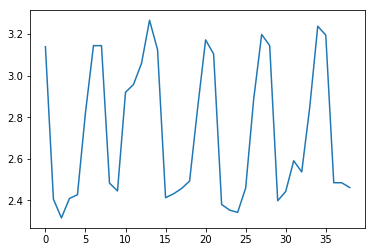

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.852847   
air_0164b9927d20bcc3_2017-04-23              1.414125   
air_0241aa3964b7f861_2017-04-23              2.385509   
air_0328696196e46f18_2017-04-23              2.135135   
air_034a3d5b40d5b1b1_2017-04-23              3.520490   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.377955  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.112888  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.864590  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.458186  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.801003

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l4_3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')